# Modelling and Evaluation Reproduction Rate Lagged Values

* In the presented notebook we will perform our modelling and evaluation on the data captured and previously explored on files [data_cleaning.ipynb](https://github.com/lucasbotellaroca/Covid-19_Reproduction_Rate_Estimator/blob/main/notebooks/01_data_cleaning.ipynb) and [data_exploration.ipnyb](https://github.com/lucasbotellaroca/Covid-19_Reproduction_Rate_Estimator/blob/main/notebooks/01_data_exploration.ipynb).

* This model and evaluation analysis **will contain the lagged variable reproduction rate of week n-2**.

* This model and evaluation analysis will work **without mobility indexes**.


# Table of contents
1. [Import libraries](#import_libraries)
2. [Authenticate to Google Drive](#auth_google)
3. [Auxiliary Functions](#auxiliary_functions)
4. [Read file and prepare data](#read_file)
5. [Feature Engineering](#feature_engineering)

    1. [Approach 1: Raw data no grouping of variables or PCA Analysis](#approach_1)
    2. [Approach 2: Grouping variables, decreasing dimensionality and correlation](#approach_2)
    3. [Approach 3: PCA](#approach_3)
2. [Modelling and Evaluation](#modelling_eval)
    1. [Phase 1](#phase_1)
        1. [Models](#models)
            1. [XGB Regressor](#xgb)
            2. [LGBM Regressor](#lgbm)
            3. [Gradient Boosting Regressor](#gbst)
            4. [KNN Regressor](#knn)
            5. [Histogram Gradient Boosting Regressor](#hist)
            6. [NuSVR](#nusvr)
        2. [Comparing Approaches](#comp)
    2. [Phase 2](#phase_2)
        1. [Evaluating Results for Approach 2](#eval_appch2_2)
        2. [Time Series Split Evaluation Approach 2](#t_series)
        3. [Assessing the R2 mismatch between train and test](#r2_mismatch)
    3. [Phase 3](#phase_3)
        1. [Time Series Train Test Split for XGB, LGBM, Gradient Boosting and Histogram Gradient Boosting](#alleval)
            1. [XGB Regressor](#xgb_2)
            2. [LGBM Regressor](#lgbm_2)
            3. [Gradient Boosting Regressor](#gbst_2)
            4. [Histogram Gradient Boosting Regressor](#hist_2)
        2. [Comparison of Time Series Train Test Split for XGB, LGBM, Gradient Boosting and Histogram Gradient Boosting](#comp_2)
3. [Model Selection, Evaluation and Conclusion](#conclusion)

## Import libraries <a name="import_libraries"></a>

In [ ]:
import pandas as pd, numpy as np, time
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import lightgbm as lgb
from xgboost import XGBRegressor
import xgboost
from xgboost import plot_importance
from xgboost import plot_tree
from sklearn import preprocessing
import shap
import altair as alt
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
%matplotlib inline

## Authenticate to Google Drive <a name="auth_google"></a>
(Request access to lucasbotellaroca@gmail.com if not conceded)

In [2]:
# A browser window will open. Login using the appropriate account.
gauth = GoogleAuth()
gauth.LocalWebserverAuth() #

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=267819126046-3da5rmgml4iemor49ermcv23tnaj02t5.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [3]:
drive = GoogleDrive(gauth)

In [4]:
drive

[Up](#table_of_contents)
## Auxiliary Functions <a name="auxiliary_functions"></a>

##### read_csv_file(folder, fileName, nrows)
Returns a dataframe from specific folder and file name from Google Drive, if not found returns empty dataframe.

In [5]:
def read_csv_file(folder, fileName, nrows):
    
    read_file = drive.ListFile({'q': "title contains '" + fileName + ".csv' and '" + folder + "' in parents"}).GetList()
    
    if len(read_file)>0:
        title = read_file[0]['title']
        id = read_file[0]['id']
        each_file = drive.CreateFile({'id': id})
        each_file.GetContentFile(title)
        df = pd.read_csv(title, skiprows=nrows)
    else:
        
        df=pd.DataFrame()
    
    return df

##### highlight_min()
Highlights minimum values for every dataframe column, used to highlight lowest erros in predictions.

In [6]:
def highlight_min(data):
    return data.style.highlight_min(color = 'lightgreen', 
                       axis = 0, subset=['mae', 'mse', 'rmse', 'mape'])

##### aux_plot_real_vs_pred()
Creates a df with test vs predicted values of reprodcution rate and creates a bar plot.

In [7]:
def aux_plot_real_vs_pred(approach, y_real, y_pred):
    plt.style.use('ggplot')
    reg_real_vs_pred = pd.DataFrame({'Actual': y_real, 'Predicted': y_pred})
    reg_real_vs_pred = reg_real_vs_pred.head(30)
    reg_real_vs_pred.plot(kind='bar', color=['darksalmon', 'teal'],figsize=(15,5)).set_title('Predicted vs Actual Approach ' + str(approach+1))
    plt.show()

##### plot_aux()
Plots measured vs predicted values for reproduction rate selected in train and test together with the perfect fit line.

In [8]:
def plot_aux(approach, y_test, y_pred, y_train, y_pred_train, ax):
    ax[approach][0].scatter(y_test, y_pred, color='cornflowerblue', alpha=.6)
    ax[approach][0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax[approach][0].set_title('Test Set Approach ' + str(approach+1))
    ax[approach][0].set_xlabel('Measured')
    ax[approach][0].set_ylabel('Predicted')
    
    ax[approach][1].scatter(y_train, y_pred_train, color='coral', alpha=.8)
    ax[approach][1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax[approach][1].set_xlabel('Measured')
    ax[approach][1].set_ylabel('Predicted')
    ax[approach][1].set_title('Train Set Approach ' + str(approach+1))
    
    
    ax[approach][2].scatter(y_pred_train,y_train-y_pred_train, color='coral', alpha=.8)
    ax[approach][2].scatter(y_pred,y_test-y_pred, color='cornflowerblue', alpha=.6)
    ax[approach][2].plot([0, y_train.max()], [0, 0], 'k--', lw=1)
    ax[approach][2].set_xlabel('Predicted Value')
    ax[approach][2].set_ylabel('Residuals')
    ax[approach][2].set_title('Residuals Plot Approach ' + str(approach+1))

##### plot_aux_2()
Plots measured vs predicted values for reproduction rate selected in train and test together with the perfect fit line. One single approach using folds in time series split

In [9]:
def plot_aux_2(approach, y_test, y_pred, y_train, y_pred_train, ax, fold):
    ax[0].scatter(y_test, y_pred, color='dodgerblue', alpha=.6)
    ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax[0].set_title('Test Set Fold ' + str(fold))
    ax[0].set_xlabel('Measured')
    ax[0].set_ylabel('Predicted')
    
    ax[1].scatter(y_train, y_pred_train, color='indigo', alpha=.6)
    ax[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax[1].set_xlabel('Measured')
    ax[1].set_ylabel('Predicted')
    ax[1].set_title('Train Set Fold ' + str(fold))
    
    
    ax[2].scatter(y_pred_train,y_train-y_pred_train, color='indigo', alpha=.6)
    ax[2].scatter(y_pred,y_test-y_pred, color='dodgerblue', alpha=.6)
    ax[2].plot([0, y_train.max()], [0, 0], 'k--', lw=1)
    ax[2].set_xlabel('Predicted Value')
    ax[2].set_ylabel('Residuals')
    ax[2].set_title('Residuals Plot Fold ' + str(fold))

##### plot_aux_3()
Plots measured vs predicted values for reproduction rate selected in train and test together with the perfect fit line. Available for any model in x,y coordinates of ax axes.

In [10]:
def aux_plot_3(model, x, y, y_test, y_pred, y_train, ax):
    
    ax[x][y].scatter(y_test, y_pred, color='cornflowerblue', alpha=.6)
    ax[x][y].plot([0, 2], [0,2], 'k--', lw=1)
    ax[x][y].set_title(model)
    ax[x][y].set_xlabel('Measured')
    ax[x][y].set_ylabel('Predicted')
    
    ax[x][y].set_xlim([0,2])
    ax[x][y].set_ylim([0,2])

##### get_values_metric()
Returns dataframes ready to plot for comparison three models with three different approaches.

In [11]:
def get_values_metric(metric):
    
    df_scores_xgb_rel=pd.DataFrame()
    df_scores_xgb_rel['Train']=df_scores_xgb_train[metric]
    df_scores_xgb_rel['Test']=df_scores_xgb[metric]
    
    df_scores_lgb_rel=pd.DataFrame()
    df_scores_lgb_rel['Train']=df_scores_lgb_train[metric]
    df_scores_lgb_rel['Test']=df_scores_lgb[metric]
    
    df_scores_gbst_rel=pd.DataFrame()
    df_scores_gbst_rel['Train']=df_scores_train_gbr[metric]
    df_scores_gbst_rel['Test']=df_scores_gbr[metric]
    
    df_scores_knn_rel=pd.DataFrame()
    df_scores_knn_rel['Train']=df_scores_knn_train[metric]
    df_scores_knn_rel['Test']=df_scores_knn[metric]
    
    df_scores_hist_rel=pd.DataFrame()
    df_scores_hist_rel['Train']=df_scores_hist_train[metric]
    df_scores_hist_rel['Test']=df_scores_hist[metric]
    
    df_scores_NuSVR_rel=pd.DataFrame()
    df_scores_NuSVR_rel['Train']=df_scores_NuSVR_train[metric]
    df_scores_NuSVR_rel['Test']=df_scores_NuSVR[metric]
    
    return df_scores_xgb_rel,df_scores_lgb_rel, df_scores_gbst_rel, df_scores_knn_rel, df_scores_hist_rel, df_scores_NuSVR_rel

##### get_metrics_data_frame()
Returns mae, mse, rmse, mape and r2 for passed values.

In [12]:
def get_metrics_data_frame(y_appch1,y_pred_1,y_appch2,y_pred_2, y_appch3, y_pred_3):

    mae_1 = mean_absolute_error(y_appch1, y_pred_1)
    mse_1 = mean_squared_error(y_appch1, y_pred_1)
    rmse_1 = np.sqrt(mean_squared_error(y_appch1, y_pred_1))
    r2_1 = r2_score(y_appch1, y_pred_1)
    mape_1 = np.mean(np.abs((y_appch1 - y_pred_1) / y_appch1)) * 100

    mae_2 = mean_absolute_error(y_appch2, y_pred_2)
    mse_2 = mean_squared_error(y_appch2, y_pred_2)
    rmse_2 = np.sqrt(mean_squared_error(y_appch2, y_pred_2))
    r2_2 = r2_score(y_appch2, y_pred_2)
    mape_2 = np.mean(np.abs((y_appch2 - y_pred_2) / y_appch2)) * 100

    mae_3 = mean_absolute_error(y_appch3, y_pred_3)
    mse_3 = mean_squared_error(y_appch3, y_pred_3)
    rmse_3 = np.sqrt(mean_squared_error(y_appch3, y_pred_3))
    r2_3 = r2_score(y_appch3, y_pred_3)
    mape_3 = np.mean(np.abs((y_appch3 - y_pred_3) / y_appch3)) * 100

    scores = { 'mae' : {'Approach 1': mae_1, 'Approach 2': mae_2, 'Approach 3': mae_3},
               'mse' : {'Approach 1': mse_1, 'Approach 2': mse_2, 'Approach 3': mse_3},
               'rmse' : {'Approach 1': rmse_1, 'Approach 2': rmse_2, 'Approach 3': rmse_3}, 
               'mape' : {'Approach 1':mape_1, 'Approach 2':mape_2, 'Approach 3':mape_3},
               'r2' : {'Approach 1':r2_1, 'Approach 2':r2_2, 'Approach 3':r2_3}}
    
    df_scores=pd.DataFrame(scores)
    
    return df_scores

##### time_test_split_custom()

Custom function that creates time series split with fixed initial value. Meaning, the model will be trained with at least n first rows, since modelling with first for example 200 rows may result in non relevant results. This function plots model outputs and returns the dataframe with all metrics for all folds.

First 700 rows are values from March 2020 till October 2020. Next 1237 rows will be used in later splits.

Therefore, we will in our first fold train until march and test the next 204 rows period wise. We will continue performing such iterations until reaching the end of the dataframe.

Last split leaves data for test from March 2021 - April 2021


***Fold n- Train(0, 700) Test(700+index, 700+index+89) where index=n89**

*We are going to be taking steps of 89 rows (537 % 6 = 89)

In [13]:
def time_test_split_custom(model, df_time):
    
    scaler = preprocessing.StandardScaler().fit(df_time[df_time.columns[3:-1]])

    X = pd.DataFrame(scaler.transform(df_time[df_time.columns[3:-1]]), columns=df_time.columns[3:-1])

    y=df_time[df_time.columns[-1]]

    aux_df=pd.DataFrame(columns=['mae', 'rmse', 'mse', 'mape', 'r2_test', 'r2_train', 'var_test', 'var_train'])

    fold = 0
    index = 0

    while ((700+index+89)<=1237): 
        
        #Split train and test
        X_train, X_test = X.iloc[0:700+index], X.iloc[700+index:700+index+89]   
        y_train, y_test = y.iloc[0:700+index], y.iloc[700+index:700+index+89]
        
        #Fit model passed as a parameter
        model.fit(X_train, y_train)
        y_pred=model.predict(X_test)
        y_pred_train=model.predict(X_train)

        #Plot fitted values
        fig, ax = plt.subplots(1,3,figsize=(15,5))
        plot_aux_2(1,y_test, y_pred, y_train, y_pred_train, ax,fold)

        #Calculate metrics
        mae = mean_absolute_error(y_pred, y_test)
        rmse = np.sqrt(mean_squared_error(y_pred, y_test))
        mse = mean_squared_error(y_pred, y_test)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

        mae = mean_absolute_error(y_pred, y_test)
        rmse = np.sqrt(mean_squared_error(y_pred, y_test))
        mse = mean_squared_error(y_pred, y_test)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

        r2_train = r2_score(y_pred_train, y_train)
        r2_test = r2_score(y_pred, y_test)
        var_train = np.var(y_train)
        var_test = np.var(y_test)
        aux_df.loc['Fold ' + str(fold)]=[mae, rmse, mse, mape, r2_test, r2_train, var_test, var_train]
        
        #Update counters
        fold = fold+1
        index=index+89
        
    return aux_df

##### get_reproduction_rate_previous_2_weeks()
* Auxiliary function that retrieves reprodcution rate of certain country 2 weeks before to current studied period.

In [14]:
def get_reproduction_rate_previous_2_weeks(df):
    rate_tendency=[]
    country='AUS'

    for index, row in df.iterrows():
        country_last=row['Code']

        if(country==country_last):

            date_1 = pd.to_datetime(row['Date']) - pd.to_timedelta(14, unit='d')
            s_1 = df[(df['Code']==country) & (pd.to_datetime(df['Date'])== date_1)]['reproduction_rate']
           

            if (s_1.size==0):

                n=row['reproduction_rate']

            else: 
               
                n=s_1.iloc[0]

            rate_tendency.append(n)

        else:
            country=country_last
            rate_tendency.append(row['reproduction_rate'])

    return rate_tendency

[Up](#table_of_contents)
## Read file and prepare data <a name="read_file"></a>

Retrieve data frame and select useful columns. After various try and error and changes in the approach of the problem there are some variables that were initially conceived to use but were later on depecredated due to non relation with our target variable reproduction rate. The mentioned variables are:
* **Doctors, nurses and beds per 1000**, such variables should affect our proxy variable excess deaths, however it does not fit well in our model since doctors, nurses and beds have no relation in the spread of the virus, it may have a relation with the number of deaths but not with the reproduction rate, therefore they have not been used.
* **Life expectancy, population greater than 65 and median age** they all might have a relation with the number oof excess deaths however they don´t fit in this model as well, since its effect is related with one of the features (our proxy variable for infections which is excesss deaths) but has no relation with our target variable reproduction rate.

We make a couple of decision regarding the data:

* Simply remove rows with missing infectious or accumulated values. Both variables are higly related with our target vairbale, and are crucial in the SIR Model, therefore, we simply remove rows that do not contain information in such variables.
* If vacciantions are null will replace them by zeros.
* We replace values smaller than zero to, since there are no "negative infections", values samller than zeo are related with no infected individuals, thus it cannot be negative.

In [15]:
#df=pd.read_csv('../df_covid_processed_final_reproduction_rate.csv')
df=read_csv_file('1kNVBQTd_m6OihGl5zXfkcbin9BtKzFEw','df_covid_processed_final_reproduction_rate',0)

df=df[['Code', 'Date','debt_relief', 'income_support', 'testing_policy',
       'international_travel_controls', 'restrictions_internal_movements',
       'close_public_transport', 'public_information_campaigns',
       'facial_coverings', 'contact_tracing', 
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'holiday', 'temp', 'prcp', 'number_of_arrivals', 'urban_population',
      'total_vaccinations_per_100', 'youth_unemployment','infections_value',
      'accumulated','reproduction_rate']]

#We still need to filter on infectious data since proxy variable is the same as accumualted and if not we would be losing importnace of that variable
df = df[df['infections_value'].notna()]
del df['infections_value']
#Since our new infectious indicator is reproduction rate week n-2 we remove it
df = df[df['accumulated'].notna()]
df['total_vaccinations_per_100'] = df['total_vaccinations_per_100'].fillna(0)
df['Date'] = pd.to_datetime(df['Date'])
    
# Grouping data over 2 week intervals in order to increment the variability and response of our features on the target variable.
df = df.groupby(['Code', pd.Grouper(key='Date', freq='2W-SUN')]).mean().reset_index()

df['reproduction_rate_week_n-2']=get_reproduction_rate_previous_2_weeks(df)
df=df[[c for c in df if c not in ['reproduction_rate']] 
       + ['reproduction_rate']]

df

Code       Date  debt_relief  income_support  testing_policy  \
0     AUS 2020-03-22     0.000000             0.0        1.000000   
1     AUS 2020-04-05     0.142857             1.0        1.000000   
2     AUS 2020-04-19     2.000000             1.0        1.000000   
3     AUS 2020-05-03     2.000000             1.0        1.000000   
4     AUS 2020-05-17     2.000000             1.0        2.428571   
...   ...        ...          ...             ...             ...   
1232  USA 2021-01-10     1.000000             2.0        3.000000   
1233  USA 2021-01-24     1.000000             2.0        3.000000   
1234  USA 2021-02-07     1.000000             2.0        3.000000   
1235  USA 2021-02-21     1.000000             2.0        3.000000   
1236  USA 2021-03-07     1.000000             2.0        3.000000   

      international_travel_controls  restrictions_internal_movements  \
0                          3.000000                              0.0   
1                          3.428571                              1.0   
2                          4.000000                              2.0   
3                          4.000000                              2.0   
4                          4.000000                              2.0   
...                             ...                              ...   
1232                       3.000000                              2.0   
1233                       3.000000                              2.0   
1234                       3.000000                              2.0   
1235                       3.000000                              2.0   
1236                       3.000000                              2.0   

      close_public_transport  public_information_campaigns  facial_coverings  \
0                        0.0                           2.0               0.0   
1                        0.0                           2.0               0.0   
2                        0.0                           2.0               0.0   
3                        0.0                           2.0               0.0   
4                        0.0                           2.0               0.0   
...                      ...                           ...               ...   
1232                     1.0                           2.0               4.0   
1233                     1.0                           2.0               4.0   
1234                     1.0                           2.0               4.0   
1235                     1.0                           2.0               4.0   
1236                     1.0                           2.0               4.0   

      ...  holiday       temp      prcp  number_of_arrivals  urban_population  \
0     ...      0.0  21.346512  0.142010           8263000.0            85.904   
1     ...      0.0  20.939890  0.053343           8263000.0            85.904   
2     ...      0.0  19.987036  0.095946           8263000.0            85.904   
3     ...      1.0  19.008360  0.046547           8263000.0            85.904   
4     ...      0.5  16.998547  0.082838           8263000.0            85.904   
...   ...      ...        ...       ...                 ...               ...   
1232  ...      0.5   2.296861  0.059487          75608000.0            82.058   
1233  ...      0.5   1.849448  0.066435          75608000.0            82.058   
1234  ...      0.5   2.291674  0.043928          75608000.0            82.058   
1235  ...      0.0  -0.303134  0.044132          75608000.0            82.058   
1236  ...      1.0  -5.009376  0.079913          75608000.0            82.058   

      total_vaccinations_per_100  youth_unemployment  accumulated  \
0                       0.000000               11.84     0.002502   
1                       0.000000               11.84     0.003440   
2                       0.000000               11.84     0.005606   
3                       0.000000               11.84     0.007019   
4                       0.000000

In [16]:
alt.Chart(df).mark_point().encode(
    x='reproduction_rate_week_n-2',
    y='reproduction_rate'
)

alt.Chart(...)

* As it can be seen values of reproduction rate in week n-2 is highly correlated with value in week n.
* It can be appreciated in the correlation matrix below as well with a correlation of 0.8.
* Values that have same value in week n-2 and week n are first entries values that do not have any previous values.

[Up](#table_of_contents)
## Feature Engineering <a name="feature_engineering"></a>

Based on the data exploration section we have conducted that lots of variables have a high correlation, which is something expected. 
* Mobility is of course affected by the measures taken, and the other way around. Also, restrictions and measures do have a high correlation between each other, restrictions are usually applied together and with simillar strictness. 

Based on the article shown (https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea)
there are three main approaches to asses the refered problem.

**1.** Drop variables, select meaningful features.

**2.** Transforming variables.

**3.** PCA: Principal Component Analysis

For our specific case, we will take three approaches.

* **Approach 1**: Raw data no grouping of variables or PCA Analysis - We first want to know how the model performs withiut any changes in our dataset.

* **Approach 2**: Grouping variables, decreasing dimensionality and correlation - We will perform feature engineering grouping variables with simillar correlations on our target variable base on the data exploration section.

* **Approach 3: PCA**: Since variables have a high correlation we will group variables taking use of Principal Component Analysis.
 
However it is stated by some staticians that grouping variables when correlated does not necesseraly mean an improvement in the predcitions.

**"The fact that some or all predictor variables are correlated among themselves does not, in general, inhibit our ability to obtain a good fit nor does it tend to affect inferences about mean responses or predictions of new observations.  —Applied Linear Statistical Models, p289, 4th Edition."**

Even though when grouping variables we might not have better predictions this might be useful in order to interpret the model afterwards, since one feature may absorb the effect of another. 
Hence, we will explore three approaches and observe which one best fits our prupose which as stated is not only getting precise predictions but also, a good interpretabily and explanation of the model itself.

In the presented problem we will work with some models that work with nul values and others that do not. In order to have appropiate datasets for all approaches with all the models evaluated we will create **2 sets of datasets for each approach**, one with raw data **df_appch_x**, no null treatment **"df_appch_x_clean"**, and another with null values treatment and standar scaling applied. Approach 3 only contains one dataset since in order to perform PCA we need the dataset to be "clean".

### Approach 1: Raw data no grouping of variables or PCA Analysis<a name="approach_1"></a>
Train models with raw data, no previous transformation or grouping done

In [17]:
df_appch1=df.copy()

In [18]:
df_appch1_clean=df.copy()
df_appch1_clean['prcp'] = df_appch1_clean['prcp'].fillna(df_appch1_clean['prcp'].mean())
df_appch1_clean['temp'] = df_appch1_clean['temp'].fillna(df_appch1_clean['temp'].mean())

### Approach 2: Grouping variables, decreasing dimensionality and correlation<a name="approach_2"></a>
Since variables seem to have high multicollinearity will group variables with similar corellation

Grouping of variables based on previous knowledge adquired in the data exploration section.

* Variables grouped as **mobility_index** are variables that have a positive relation in the spread of the virus. Those variables are "retail_and_recreation", "transit_stations", "grocery_and_pharmacy", "workplaces". They have been ponderated to an approximation of more or less effect on the response variable.

* Variables grouped as **awareness_measures** are variables that represent the conciency and awareness given from governments to the population, most meaningful one is "facial_coverings".

* Variables grouped as **economic_measures** are measures that support debt and income, which prevents workers from going to work and thus decreasing mobility and activity.

* Variables grouped as **health_measures** are measures that support tracing and testing of cases.

* Variables grouped as **mobility_closure_measures** are measures that limit mobility and interactions between individuals of different households and cities. It also measures that limit usual work and school life together with events.

There are some other variables such as: 'residential', 'holiday', 'temp', 'prcp','number_of_arrivals', 'urban_population','total_vaccinations_per_100', 'youth_unemployment','infections_value', 'accumulated' are not modified nor grouped since they appear to be independent from each other and its effect on the response variable.

In [19]:
df_appch2=df.copy()

In [20]:
df_appch2['awareness_measures'] = df_appch2['public_information_campaigns']*0.2+df_appch2['facial_coverings']*0.8

df_appch2['economic_measures']=df_appch2['debt_relief']*0.5+df_appch2['income_support']*0.5
df_appch2['health_measures']=df_appch2['contact_tracing']*0.5+df_appch2['testing_policy']*0.5
df_appch2['mobility_closures_measures']=0.3*df_appch2['stay_home_requirements']\
                                + 0.3*df_appch2['restriction_gatherings']\
                                + 0.2*df_appch2['restrictions_internal_movements']\
                                + 0.1*df_appch2['international_travel_controls']\
                                + 0.1*df_appch2['close_public_transport']\
                                + 0.2*df_appch2['cancel_public_events']\
                                + 0.4*df_appch2['workplace_closures']\
                                + 0.4*df_appch2['school_closures']

df_appch2=df_appch2[['Code', 'Date',
                     'awareness_measures', 'health_measures',
                     'mobility_closures_measures', 'economic_measures',
                     'holiday', 'temp', 'prcp', 
                     'number_of_arrivals', 'urban_population',
                     'total_vaccinations_per_100', 'youth_unemployment',
            'accumulated', 'reproduction_rate_week_n-2','reproduction_rate']]

In [21]:
df_appch2.head()

Code       Date  awareness_measures  health_measures  \
0  AUS 2020-03-22                 0.4         1.500000   
1  AUS 2020-04-05                 0.4         1.500000   
2  AUS 2020-04-19                 0.4         1.500000   
3  AUS 2020-05-03                 0.4         1.500000   
4  AUS 2020-05-17                 0.4         2.214286   

   mobility_closures_measures  economic_measures  holiday       temp  \
0                    0.300000           0.000000      0.0  21.346512   
1                    1.657143           0.571429      0.0  20.939890   
2                    4.785714           1.500000      0.0  19.987036   
3                    4.857143           1.500000      1.0  19.008360   
4                    4.600000           1.500000      0.5  16.998547   

       prcp  number_of_arrivals  urban_population  total_vaccinations_per_100  \
0  0.142010           8263000.0            85.904                         0.0   
1  0.053343           8263000.0            85.904                         0.0   
2  0.095946           8263000.0            85.904                         0.0   
3  0.046547           8263000.0            85.904                         0.0   
4  0.082838           8263000.0            85.904                         0.0   

   youth_unemployment  accumulated  reproduction_rate_week_n-2  \
0               11.84     0.002502                    2.170000   
1               11.84     0.003440                    2.170000   
2               11.84     0.005606                    2.305000   
3               11.84     0.007019                    1.111429   
4               11.84     0.008205                    0.432857   

   reproduction_rate  
0           2.170000  
1           2.305000  
2           1.111429  
3           0.432857  
4           0.589286

* As seen multicollinearity is still veasible with some measures, mobility index and residential are opposed which makes sense, and measures tend to have high correlation with mobility and residential trends

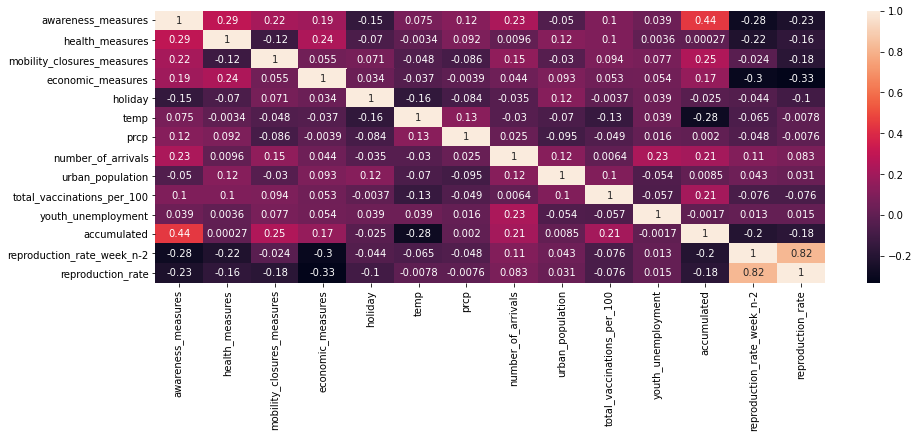

In [22]:
plt.rcParams["figure.figsize"] = (15,5)
corrMatrix = df_appch2.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

* As seen reproduction_rate_n-2 is higly correlated with reproduction_rate

In [23]:
df_appch2_clean=df_appch2.copy()
df_appch2_clean['prcp'] = df_appch2_clean['prcp'].fillna(df_appch2_clean['prcp'].mean())
df_appch2_clean['temp'] = df_appch2_clean['temp'].fillna(df_appch2_clean['temp'].mean())

In [24]:
df_appch2_clean.columns

Index(['Code', 'Date', 'awareness_measures', 'health_measures',
       'mobility_closures_measures', 'economic_measures', 'holiday', 'temp',
       'prcp', 'number_of_arrivals', 'urban_population',
       'total_vaccinations_per_100', 'youth_unemployment', 'accumulated',
       'reproduction_rate_week_n-2', 'reproduction_rate'],
      dtype='object')

### Approach 3: PCA<a name="approach_3"></a>
Since variables have a high correlation we will group variables taking use of Principal Component Analysis

In [25]:
df_appch3=df.copy()
df_appch3['temp'] = df_appch3['temp'].fillna(df_appch3['temp'].mean())
df_appch3['prcp'] = df_appch3['prcp'].fillna(df_appch3['prcp'].mean())

In [26]:
df_appch3.columns

Index(['Code', 'Date', 'debt_relief', 'income_support', 'testing_policy',
       'international_travel_controls', 'restrictions_internal_movements',
       'close_public_transport', 'public_information_campaigns',
       'facial_coverings', 'contact_tracing', 'stay_home_requirements',
       'restriction_gatherings', 'cancel_public_events', 'workplace_closures',
       'school_closures', 'holiday', 'temp', 'prcp', 'number_of_arrivals',
       'urban_population', 'total_vaccinations_per_100', 'youth_unemployment',
       'accumulated', 'reproduction_rate_week_n-2', 'reproduction_rate'],
      dtype='object')

In [27]:
features=['debt_relief',
       'income_support', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings', 'contact_tracing',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'holiday', 'temp', 'prcp', 'total_vaccinations_per_100',
       'accumulated', 'reproduction_rate_week_n-2', 'reproduction_rate']

# Separating out the features
x = df_appch3.reindex(columns = features).values
# Separating out the target
y = df_appch3.reindex(columns = ['reproduction_rate']).values
# Standardizing the features
x = StandardScaler().fit_transform(x)

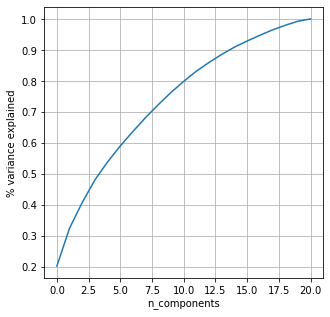

In [28]:
pca = PCA(n_components = x.shape[1])
pca_data = pca.fit_transform(x)

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()

In [29]:
pca = PCA(n_components = 15)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
#Include Date and R0 for later filtering
principalDf['Date']=df_appch3['Date']
principalDf['reproduction_rate']=df_appch3['reproduction_rate']
df_appch3=principalDf

[Up](#table_of_contents)
## Modelling and Evaluation<a name="modelling_eval"></a>

Once we have our three datasets defined we will start with the modelling and evaluation phase.

* The evaluation has not been done randomly since entries in the dataset may have very simillar behaviours and we should expect some false "good-fits", as it has been eperienced. Therefore we will base our evalaution for every model in a **time series split**. Time series are trained with first n entries in time and they are later evaluated with n post entries after date defined.

* Since our evaluation is complex and contains three approaches, together with six different models, we will evaluate what would correspond to an split in time of **2020 year for train** and **2021 for test**. Once we have some intuition of what the best models are based on this configuration, we will test the best models observed in this section using iterative time series split. For this in detail analysis we will use approach 2 sinceit has been recorded and evaluated to be the model getting best results and explainability of its features based on further analysis taken advanatge of SHAP values.

* As mentioned we will create two sets of data for each of the three approachs mentioned,one raw, and another "clean" with null treatement and standard scaling applied. 

* We will aknowledge the differences between **r2 scores** in train and test at then end of the presented notebook, giving an explanation on why it is happening an how it affects our evaluation of the presented models.

In [30]:
date=pd.Timestamp(2021, 1, 10)

#### Approach 1: Raw data no grouping of variables or PCA Analysis Split

In [31]:
X_1=df_appch1[(pd.to_datetime(df_appch1['Date']) <= date)]
X_2=df_appch1[(pd.to_datetime(df_appch1['Date']) > date)]
X_train_appch1=X_1[X_1.columns[2:-1]]
X_test_appch1=X_2[X_2.columns[2:-1]]
y_train_appch1=X_1['reproduction_rate']
y_test_appch1=X_2['reproduction_rate']

In [32]:
X_1_clean=df_appch1_clean[(pd.to_datetime(df_appch1_clean['Date']) <= date)]
X_2_clean=df_appch1_clean[(pd.to_datetime(df_appch1_clean['Date']) > date)]
scaler = preprocessing.StandardScaler().fit(df_appch1_clean[df_appch1_clean.columns[2:-1]])

X_train_appch1_clean = pd.DataFrame(scaler.transform(X_1_clean[X_1_clean.columns[2:-1]]),columns=df_appch1_clean.columns[2:-1])
X_test_appch1_clean = pd.DataFrame(scaler.transform(X_2_clean[X_2_clean.columns[2:-1]]), columns=df_appch1_clean.columns[2:-1])

y_train_appch1_clean=X_1_clean['reproduction_rate']
y_test_appch1_clean=X_2_clean['reproduction_rate']

####  Approach 2: Grouping variables, decreasing dimensionality and correlation Split

In [33]:
X_1=df_appch2[(pd.to_datetime(df_appch2['Date']) <= date)]
X_2=df_appch2[(pd.to_datetime(df_appch2['Date']) > date)]
X_train_appch2=X_1[X_1.columns[2:-1]]
X_test_appch2=X_2[X_2.columns[2:-1]]
y_train_appch2=X_1['reproduction_rate']
y_test_appch2=X_2['reproduction_rate']

In [34]:
X_1_clean=df_appch2_clean[(pd.to_datetime(df_appch2_clean['Date']) <= date)]
X_2_clean=df_appch2_clean[(pd.to_datetime(df_appch2_clean['Date']) > date)]
scaler_appch2 = preprocessing.StandardScaler().fit(df_appch2_clean[df_appch2_clean.columns[2:-1]])

X_train_appch2_clean = pd.DataFrame(scaler_appch2.transform(X_1_clean[X_1_clean.columns[2:-1]]), columns=df_appch2_clean.columns[2:-1])
X_test_appch2_clean = pd.DataFrame(scaler_appch2.transform(X_2_clean[X_2_clean.columns[2:-1]]), columns=df_appch2_clean.columns[2:-1])

y_train_appch2_clean=X_1_clean['reproduction_rate']
y_test_appch2_clean=X_2_clean['reproduction_rate']

#### Approach 3: PCA  Split

In [35]:
X_1=df_appch3[(pd.to_datetime(df_appch3['Date']) <= date)]
X_2=df_appch3[(pd.to_datetime(df_appch3['Date']) > date)]
X_train_appch3=X_1[X_1.columns[0:-2]]
X_test_appch3=X_2[X_2.columns[0:-2]]
y_train_appch3=X_1['reproduction_rate']
y_test_appch3=X_2['reproduction_rate']

In [36]:
X_train_appch3_clean=X_train_appch3
X_test_appch3_clean=X_test_appch3
y_train_appch3_clean=y_train_appch3
y_test_appch3_clean=y_test_appch3

#### Dataframe for later evaluation of approach 2

After some evaluation of the following models it has been stated and evaluated that the best approach is approach 2 and is the one that provides better explainability for afterwards analysis. Taken this into account, we will store all metrics for every different model in order to evaluate best model and later in detail analysis using time series split. 

In [37]:
df_eval_approach_2=pd.DataFrame(columns=['mae','mse','mape','rmse', 'r2'])

[Up](#table_of_contents)
# Phase 1<a name="phase_1"></a>
* Evaluate best model approach with one single time series split year 2020 for train and year 2021 for test. This will be an evaluation upon all approaches, in order to select best approach. After various iterance on modelling, it has been detected that approach number 2 is the one that provides better specially in terms of explicability of the models due to multicollinearity between variables. Therefore, after all Approach 2 has been selected in order to perform in detail analysis to select best model based on metrics and SHAP values. However we will still view how models respond to different dataset approaches.

## Models<a name="models"></a>

## XGBoost Regressor<a name="xgb"></a>

### Modelling
Parameter selection has been done over try and error in order to avoid under-fitting or over-fitting.

In [38]:
# A parameter grid for XGBoost
fit_params1={'max_depth' : [4,6,8], 'colsample_bytree':[0.5]}
fit_params2={'max_depth' : [4,6,8], 'colsample_bytree':[0.5]}
fit_params3={'max_depth' : [8,9,10], 'colsample_bytree':[0.5]}

# Initialize XGB and GridSearch
xgb = XGBRegressor() 

grid1_xgb = GridSearchCV(xgb, fit_params1, verbose=0, n_jobs=-1)
grid2_xgb = GridSearchCV(xgb, fit_params2, verbose=0, n_jobs=-1)
grid3_xgb = GridSearchCV(xgb, fit_params3, verbose=0, n_jobs=-1)

In [39]:
%time

eval_set1 = [(X_train_appch1, y_train_appch1), (X_test_appch1, y_test_appch1)]
eval_set2 = [(X_train_appch2, y_train_appch2), (X_test_appch2, y_test_appch2)]
eval_set3 = [(X_train_appch3, y_train_appch3), (X_test_appch3, y_test_appch3)]

grid1_xgb.fit(X_train_appch1, y_train_appch1, eval_set=eval_set1, early_stopping_rounds=5, verbose=False)
grid2_xgb.fit(X_train_appch2, y_train_appch2, eval_set=eval_set2, early_stopping_rounds=5, verbose=False)
grid3_xgb.fit(X_train_appch3, y_train_appch3, eval_set=eval_set3, early_stopping_rounds=5, verbose=False)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [40]:
y_pred_1_xgb=grid1_xgb.best_estimator_.predict(X_test_appch1)
y_pred_train_1_xgb=grid1_xgb.best_estimator_.predict(X_train_appch1)
y_pred_2_xgb=grid2_xgb.best_estimator_.predict(X_test_appch2)
y_pred_train_2_xgb=grid2_xgb.best_estimator_.predict(X_train_appch2)
y_pred_3_xgb=grid3_xgb.best_estimator_.predict(X_test_appch3)
y_pred_train_3_xgb=grid3_xgb.best_estimator_.predict(X_train_appch3)

### XGB Evaluation

#### Test Set

In [41]:
df_scores_xgb=get_metrics_data_frame(y_test_appch1,y_pred_1_xgb, y_test_appch2, y_pred_2_xgb,y_test_appch3, y_pred_3_xgb)
df_eval_approach_2.loc['XGBoost Regressor'] = df_scores_xgb.loc['Approach 2']
highlight_min(df_scores_xgb)

#### Train Set

In [42]:
df_scores_xgb_train=get_metrics_data_frame(y_train_appch1,y_pred_train_1_xgb, y_train_appch2, y_pred_train_2_xgb,y_train_appch3, y_pred_train_3_xgb)
highlight_min(df_scores_xgb_train)

## Results View

#### Actual vs Predicted

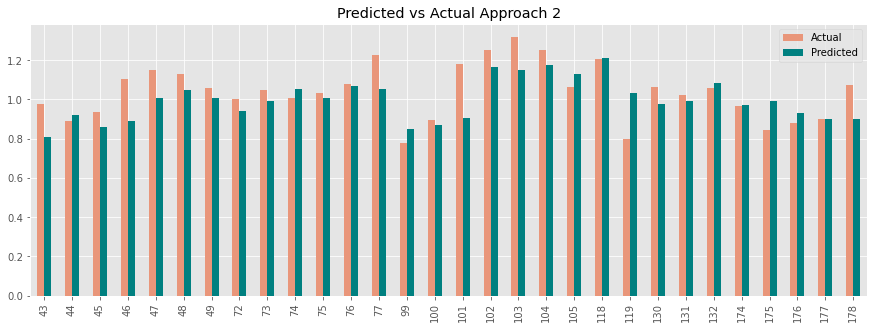

In [43]:
aux_plot_real_vs_pred(1, y_test_appch2, y_pred_2_xgb)

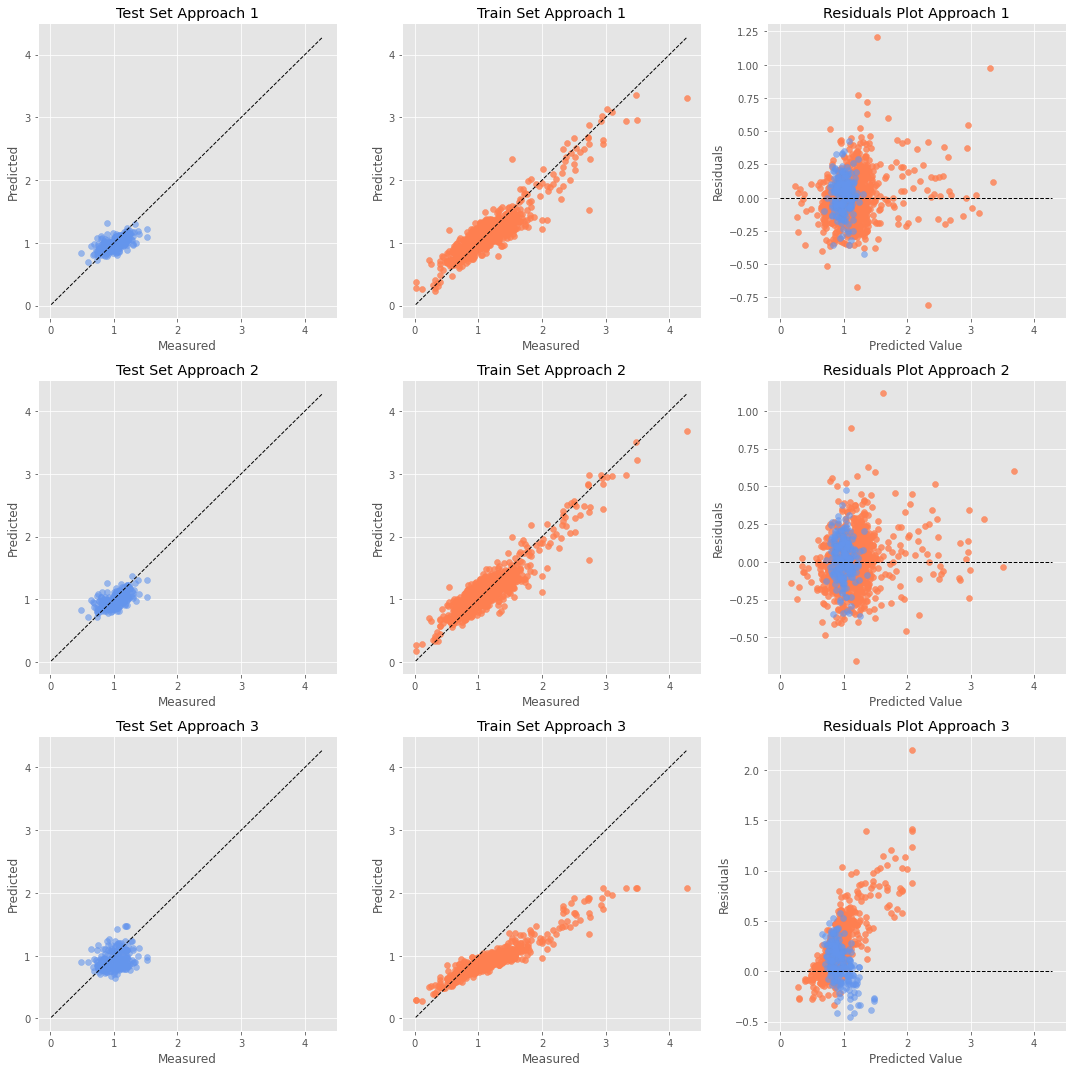

In [44]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

plot_aux(0, y_test_appch1, y_pred_1_xgb, y_train_appch1, y_pred_train_1_xgb, ax)
plot_aux(1, y_test_appch2, y_pred_2_xgb, y_train_appch2, y_pred_train_2_xgb, ax)
plot_aux(2, y_test_appch3, y_pred_3_xgb, y_train_appch3, y_pred_train_3_xgb, ax)

fig.tight_layout()
plt.show()

* As seen **Approach 2** together with Approach 1 seems to be getting the best result in the test set and is the one getting the best fit to the predicted-measured line.
* Approach 3 seems to be getting bad results. 
* It is also important to note that the **test set has a smaller range of values (0.5, 1.5) than the train set (0, 4.5)** and its concentration and variance is higher.
* There are no signs of overfitting based on the plots shown together with the analysis in the residuals plot.
* Results in terms of metrics seem to have improved from methodology without lagged values [03_data_model_evaluation.ipynb](https://github.com/lucasbotellaroca/Covid-19_Reproduction_Rate_Estimator/blob/main/notebooks/03_data_model_evaluation.ipynb)

#### Shap Values

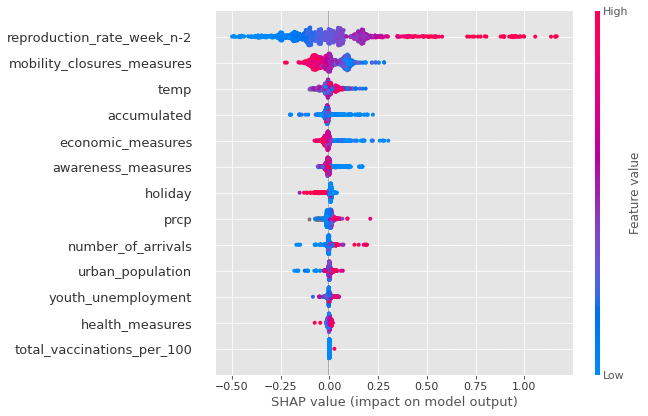

In [45]:
shap_values = shap.TreeExplainer(grid2_xgb.best_estimator_).shap_values(X_train_appch2)
shap.summary_plot(shap_values, X_train_appch2)

In [46]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train_appch2.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance['percentage_change']= 100*feature_importance['feature_importance_vals']/y_train_appch2.mean()
feature_importance

col_name  feature_importance_vals  percentage_change
12  reproduction_rate_week_n-2                 0.170735          14.834075
2   mobility_closures_measures                 0.061215           5.318596
5                         temp                 0.024624           2.139431
11                 accumulated                 0.023148           2.011142
3            economic_measures                 0.021204           1.842250
0           awareness_measures                 0.017649           1.533433
4                      holiday                 0.014058           1.221418
6                         prcp                 0.013150           1.142480
7           number_of_arrivals                 0.010555           0.917072
8             urban_population                 0.006918           0.601034
10          youth_unemployment                 0.006775           0.588666
1              health_measures                 0.004538           0.394301
9   total_vaccinations_per_100                 0.000100           0.008677

* SHAP values represented above seem to follow good logic and explainability. Although there are some measures that do not follow a proper logic based on evidence. Overall we will find this model as a candidate in terms of interpretability.
* However some features seem to have very low importance, remarkable low value of awareness measures and health measures.

## Light GBM<a name="lgbm"></a>

### Modelling 
Parameter selection has been done over try and error in order to avoid under-fitting or over-fitting.

In [47]:
fit_params1={'max_depth' : [4,5,6], 'n_estimators':[42,43,44]}
fit_params2={'max_depth' : [4,5,6], 'n_estimators':[34,35,36]}
fit_params3={'max_depth' : [4,5,6], 'n_estimators':[34,35,36]}


# Initialize LGB and GridSearch
lgbm = lgb.LGBMRegressor()

grid1_lgb = GridSearchCV(lgbm, fit_params1, verbose=0)
grid2_lgb = GridSearchCV(lgbm, fit_params2, verbose=0)
grid3_lgb = GridSearchCV(lgbm, fit_params3, verbose=0)

In [48]:
%%time

eval_set1 = [(X_train_appch1, y_train_appch1), (X_test_appch1, y_test_appch1)]
eval_set2 = [(X_train_appch2, y_train_appch2), (X_test_appch2, y_test_appch2)]
eval_set3 = [(X_train_appch3, y_train_appch3), (X_test_appch3, y_test_appch3)]

grid1_lgb.fit(X_train_appch1, y_train_appch1, eval_set=eval_set1, verbose=False)
grid2_lgb.fit(X_train_appch2, y_train_appch2, eval_set=eval_set2, verbose=False)
grid3_lgb.fit(X_train_appch3, y_train_appch3, eval_set=eval_set3, verbose=False)

CPU times: user 27.2 s, sys: 816 ms, total: 28 s
Wall time: 7.55 s


GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'max_depth': [4, 5, 6], 'n_estimators': [34, 35, 36]})

In [49]:
grid1_lgb.best_params_, grid2_lgb.best_params_, grid3_lgb.best_params_

({'max_depth': 5, 'n_estimators': 42},
 {'max_depth': 5, 'n_estimators': 35},
 {'max_depth': 6, 'n_estimators': 36})

In [50]:
y_pred_1_lgb=grid1_lgb.best_estimator_.predict(X_test_appch1)
y_pred_train_1_lgb=grid1_lgb.best_estimator_.predict(X_train_appch1)
y_pred_2_lgb=grid2_lgb.best_estimator_.predict(X_test_appch2)
y_pred_train_2_lgb=grid2_lgb.best_estimator_.predict(X_train_appch2)
y_pred_3_lgb=grid3_lgb.best_estimator_.predict(X_test_appch3)
y_pred_train_3_lgb=grid3_lgb.best_estimator_.predict(X_train_appch3)

### Evaluation

#### Test Set

In [51]:
df_scores_lgb=get_metrics_data_frame(y_test_appch1,y_pred_1_lgb, y_test_appch2, y_pred_2_lgb,y_test_appch3, y_pred_3_lgb)
df_eval_approach_2.loc['Light GBM'] = df_scores_lgb.loc['Approach 2']
highlight_min(df_scores_lgb)

#### Train Set

In [52]:
df_scores_lgb_train=get_metrics_data_frame(y_train_appch1,y_pred_train_1_lgb, y_train_appch2, y_pred_train_2_lgb,y_train_appch3, y_pred_train_3_lgb)
highlight_min(df_scores_lgb_train)

## Results View

#### Actual vs Predicted

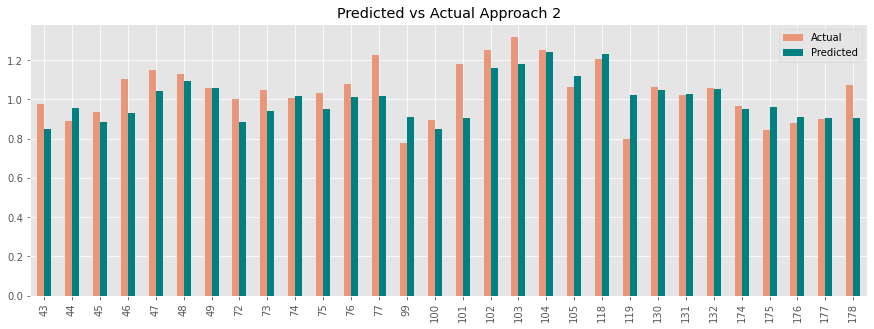

In [53]:
aux_plot_real_vs_pred(1, y_test_appch2, y_pred_2_lgb)

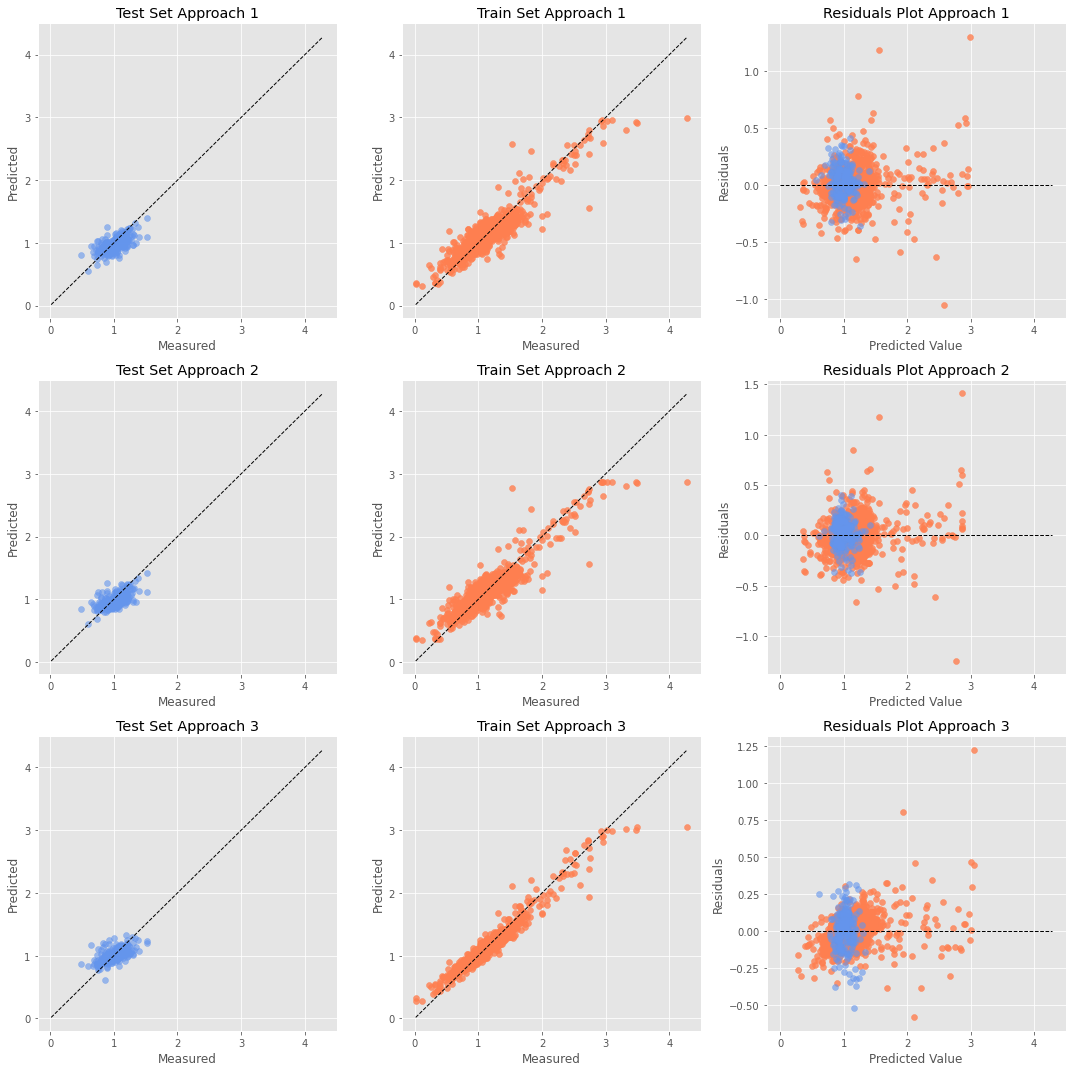

In [54]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

plot_aux(0, y_test_appch1, y_pred_1_lgb, y_train_appch1, y_pred_train_1_lgb, ax)
plot_aux(1, y_test_appch2, y_pred_2_lgb, y_train_appch2, y_pred_train_2_lgb, ax)
plot_aux(2, y_test_appch3, y_pred_3_lgb, y_train_appch3, y_pred_train_3_lgb, ax)

fig.tight_layout()
plt.show()

* As seen **Approach 1** together with Approach 2 seems to be getting the best result in the test set and is the one getting the best fit to the predicted-measured line.
* Approach 3 seems to be getting good results. 
* However this model seems to be getting **better results than XGB** in general terms, however we will analyze this in further detail later on. 
* It is also important to note that **test set has a smaller range of values (0.5,1.5) than the train set (0, 4.5)** and its concentration and variance is higher.
* There are no signs of overfitting based on the plots shown together with the analysis in the residuals plot.
* Results in terms of metrics seem to have improved from methodology without lagged values [03_data_model_evaluation.ipynb](https://github.com/lucasbotellaroca/Covid-19_Reproduction_Rate_Estimator/blob/main/notebooks/03_data_model_evaluation.ipynb)

### Shap Values 

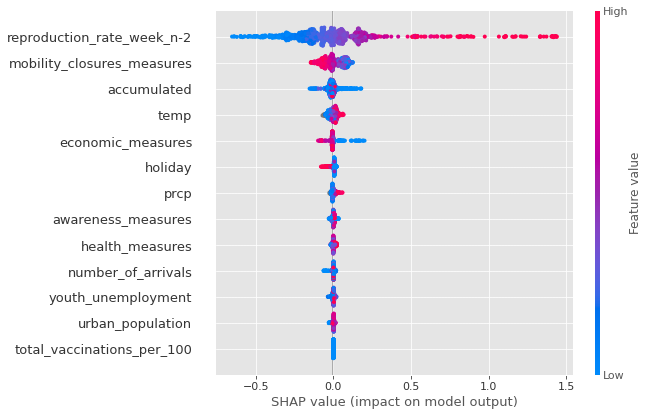

In [55]:
shap_values = shap.TreeExplainer(grid2_lgb.best_estimator_).shap_values(X_train_appch2)
shap.summary_plot(shap_values, X_train_appch2)

In [56]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train_appch2.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance['percentage_change']= 100*feature_importance['feature_importance_vals']/y_train_appch2.mean()
feature_importance

col_name  feature_importance_vals  percentage_change
12  reproduction_rate_week_n-2                 0.210416          18.281672
2   mobility_closures_measures                 0.052132           4.529403
11                 accumulated                 0.022870           1.987048
5                         temp                 0.019025           1.652917
3            economic_measures                 0.012116           1.052698
4                      holiday                 0.009782           0.849926
6                         prcp                 0.007989           0.694073
0           awareness_measures                 0.005688           0.494232
1              health_measures                 0.004921           0.427567
7           number_of_arrivals                 0.004228           0.367382
10          youth_unemployment                 0.004029           0.350012
8             urban_population                 0.003118           0.270867
9   total_vaccinations_per_100                 0.000000           0.000000

* SHAP values represented above seem to follow good logic and explainability. Although there are some measures that do not follow a proper logic based on evidence. Overall we will find this model as a candidate in terms of interpretability.
* However some features seem to have very low importance, remarkable low value of awareness measures and health measures.
* Temperature has different sign from other shap values evaluation in methodology with no lag values.

## Gradient Boosting Regressor<a name="gbst"></a> 
Parameter selection has been done over try and error in order to avoid under-fitting or over-fitting. In this case we have selected **max_depth to be 3** in order to avoid over-fitting.

In [57]:
reg1_gbr = GradientBoostingRegressor(max_depth=3)
reg2_gbr = GradientBoostingRegressor(max_depth=3)
reg3_gbr = GradientBoostingRegressor(max_depth=2)

reg1_gbr.fit(X_train_appch1_clean, y_train_appch1_clean)
reg2_gbr.fit(X_train_appch2_clean, y_train_appch2_clean)
reg3_gbr.fit(X_train_appch3_clean, y_train_appch3_clean)


y_pred_1_gbr=reg1_gbr.predict(X_test_appch1_clean)
y_pred_train_1_gbr=reg1_gbr.predict(X_train_appch1_clean)
y_pred_2_gbr=reg2_gbr.predict(X_test_appch2_clean)
y_pred_train_2_gbr=reg2_gbr.predict(X_train_appch2_clean)
y_pred_3_gbr=reg3_gbr.predict(X_test_appch3_clean)
y_pred_train_3_gbr=reg3_gbr.predict(X_train_appch3_clean)

### Evaluation

#### Test Set

In [58]:
df_scores_gbr=get_metrics_data_frame(y_test_appch1_clean,y_pred_1_gbr, y_test_appch2_clean, y_pred_2_gbr,y_test_appch3_clean, y_pred_3_gbr)
df_eval_approach_2.loc['Gradient Boosting'] = df_scores_gbr.loc['Approach 2']
highlight_min(df_scores_gbr)

#### Train Set

In [59]:
df_scores_train_gbr=get_metrics_data_frame(y_train_appch1_clean,y_pred_train_1_gbr, y_train_appch2_clean, y_pred_train_2_gbr,y_train_appch3_clean, y_pred_train_3_gbr)
highlight_min(df_scores_train_gbr)


## Results View

#### Actual vs Predicted

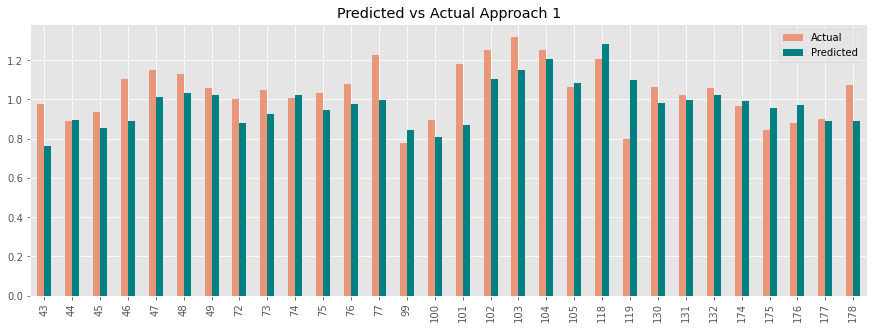

In [60]:
aux_plot_real_vs_pred(0, y_test_appch1_clean, y_pred_1_gbr)

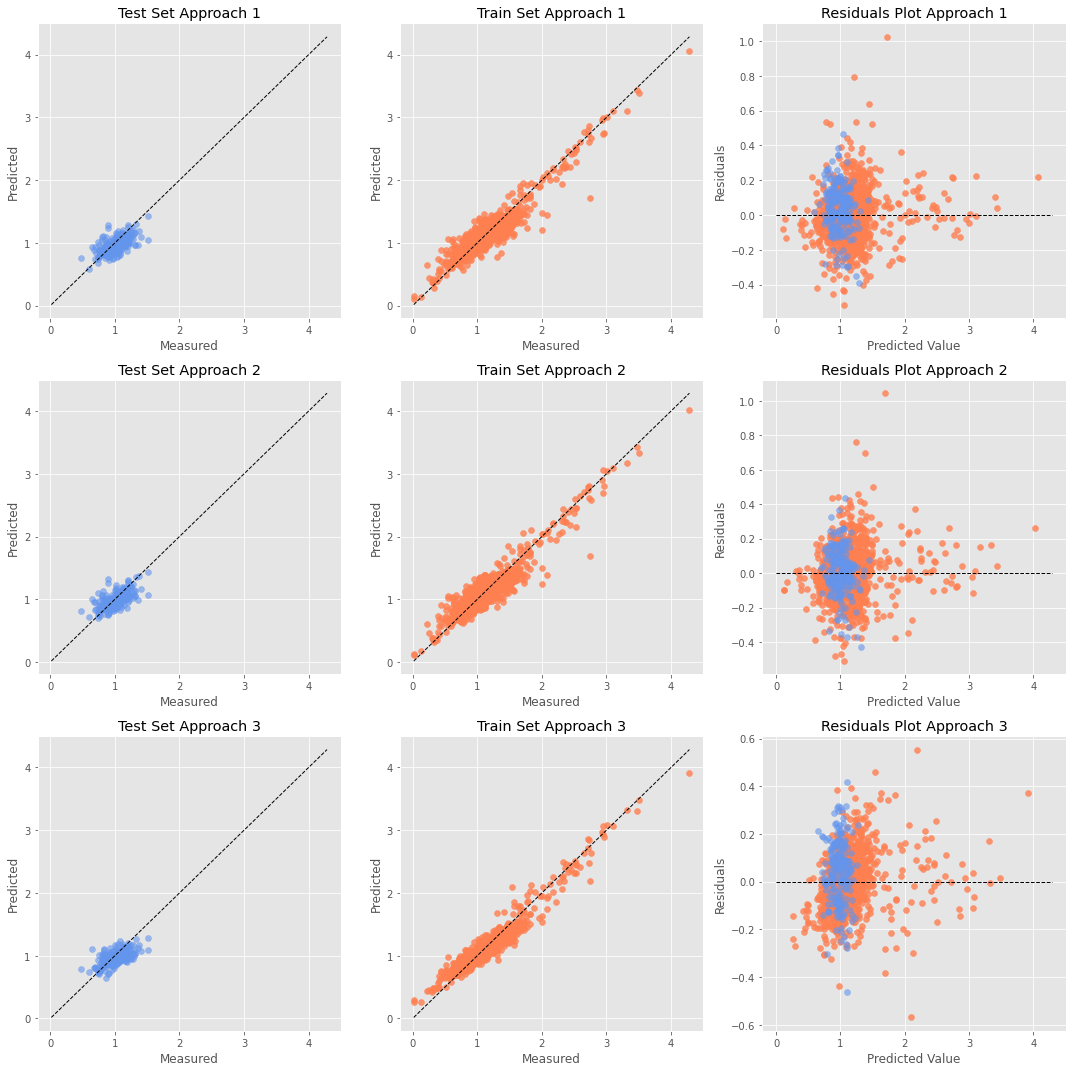

In [61]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

plot_aux(0, y_test_appch1_clean, y_pred_1_gbr, y_train_appch1_clean, y_pred_train_1_gbr, ax)
plot_aux(1, y_test_appch2_clean, y_pred_2_gbr, y_train_appch2_clean, y_pred_train_2_gbr, ax)
plot_aux(2, y_test_appch3_clean, y_pred_3_gbr, y_train_appch3_clean, y_pred_train_3_gbr, ax)

fig.tight_layout()
plt.show()

* As seen **Approach 2** together with Approach 1 seems to be getting the best result in the test set and is the one getting the best fit to the predicted-measured line.
* However this model seems to be getting **simillar results than XGB and LGBM** in general terms, however we will analyze this in further detail later on. But we can appreciate a good fit of approach 1 and 2  that seems to be better than previous models.
* It is also important to note that the **test set has a smaller range of values (0.5, 1.5) than the train set (0, 4.5)** and its concentration and variance is higher.
* There are no signs of overfitting based on the plots shown together with the analysis in the residuals plot.
* Results in terms of metrics seem to have improved from methodology without lagged values [03_data_model_evaluation.ipynb](https://github.com/lucasbotellaroca/Covid-19_Reproduction_Rate_Estimator/blob/main/notebooks/03_data_model_evaluation.ipynb)

### Shap Values 

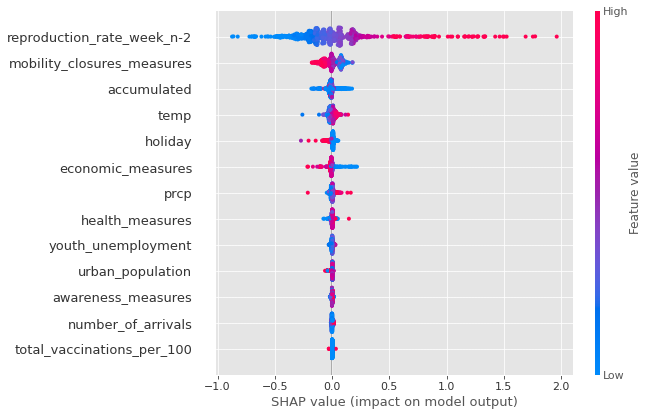

In [62]:
shap_values = shap.TreeExplainer(reg2_gbr).shap_values(X_train_appch2_clean)
shap.summary_plot(shap_values, X_train_appch2_clean)

In [63]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train_appch2.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance['percentage_change']= 100*feature_importance['feature_importance_vals']/y_train_appch2.mean()
feature_importance

col_name  feature_importance_vals  percentage_change
12  reproduction_rate_week_n-2                 0.219228          19.047335
2   mobility_closures_measures                 0.055805           4.848551
11                 accumulated                 0.022614           1.964747
5                         temp                 0.019988           1.736621
4                      holiday                 0.014237           1.236954
3            economic_measures                 0.012811           1.113056
6                         prcp                 0.010394           0.903072
1              health_measures                 0.006711           0.583076
10          youth_unemployment                 0.004942           0.429404
8             urban_population                 0.003643           0.316487
0           awareness_measures                 0.003528           0.306514
7           number_of_arrivals                 0.002905           0.252439
9   total_vaccinations_per_100                 0.000244           0.021203

* SHAP values represented above seem to follow good logic and explainability. Although there are some measures that do not follow a proper logic based on evidence. Overall we will find this model as a candidate in terms of interpretability.
* However some features seem to have very low importance, remarkable low value of awareness measures and health measures.
* Temperature has different sign from other shap values evaluationin methodology with no lag values.

## K Nearest Neighbour Regressor<a name="knn"></a>
Parameter selection has been done over try and error in order to avoid under-fitting or over-fitting. In this case we have not modificated default parameters.

In [64]:
reg1_knn = KNeighborsRegressor()
reg2_knn = KNeighborsRegressor()
reg3_knn = KNeighborsRegressor()

reg1_knn.fit(X_train_appch1_clean, y_train_appch1_clean)
reg2_knn.fit(X_train_appch2_clean, y_train_appch2_clean)
reg3_knn.fit(X_train_appch3_clean, y_train_appch3_clean)

y_pred_1_knn=reg1_knn.predict(X_test_appch1_clean)
y_pred_train_1_knn=reg1_knn.predict(X_train_appch1_clean)
y_pred_2_knn=reg2_knn.predict(X_test_appch2_clean)
y_pred_train_2_knn=reg2_knn.predict(X_train_appch2_clean)
y_pred_3_knn=reg3_knn.predict(X_test_appch3_clean)
y_pred_train_3_knn=reg3_knn.predict(X_train_appch3_clean)

### Evaluation

#### Test Set

In [65]:
df_scores_knn=get_metrics_data_frame(y_test_appch1_clean,y_pred_1_knn, y_test_appch2_clean, y_pred_2_knn,y_test_appch3_clean, y_pred_3_knn)
df_eval_approach_2.loc['KNN'] = df_scores_knn.loc['Approach 2']
highlight_min(df_scores_knn)

#### Train Set

In [66]:
df_scores_knn_train=get_metrics_data_frame(y_train_appch1_clean,y_pred_train_1_knn, y_train_appch2_clean, y_pred_train_2_knn,y_train_appch3_clean, y_pred_train_3_knn)
highlight_min(df_scores_knn_train)

## Results View

#### Actual vs Predicted

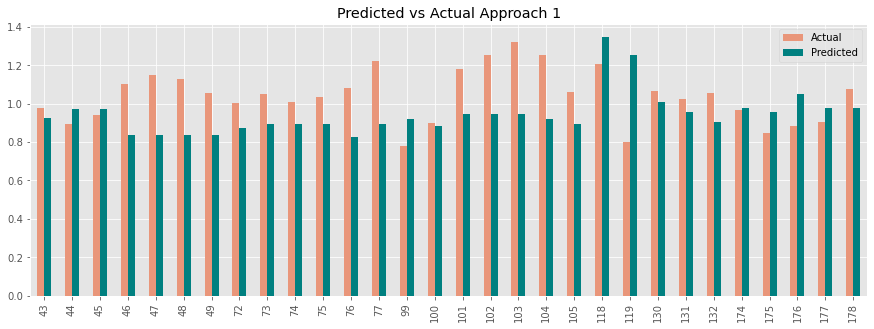

In [67]:
aux_plot_real_vs_pred(0, y_test_appch1_clean, y_pred_1_knn)

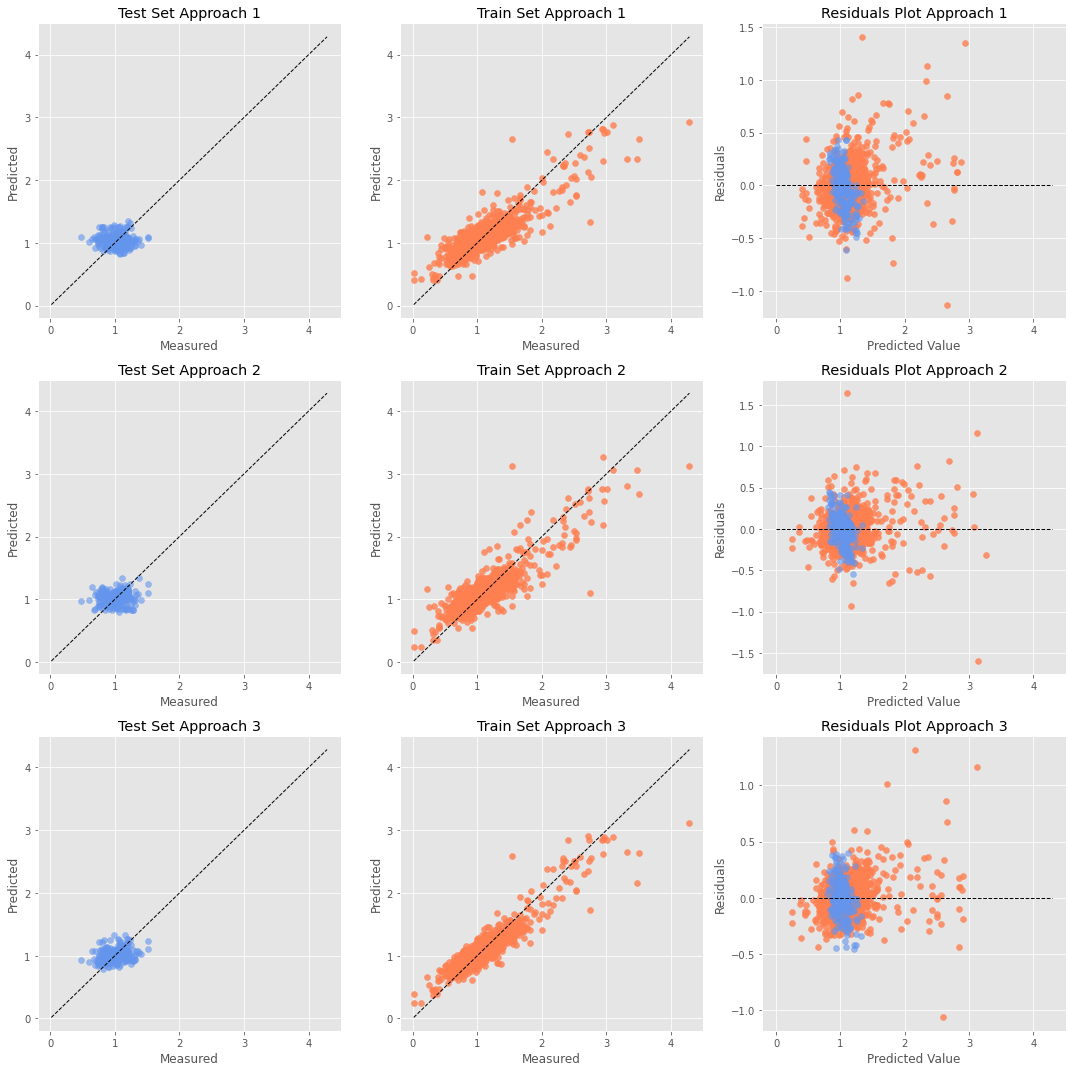

In [68]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

plot_aux(0, y_test_appch1_clean, y_pred_1_knn, y_train_appch1_clean, y_pred_train_1_knn, ax)
plot_aux(1, y_test_appch2_clean, y_pred_2_knn, y_train_appch2_clean, y_pred_train_2_knn, ax)
plot_aux(2, y_test_appch3_clean, y_pred_3_knn, y_train_appch3_clean, y_pred_train_3_knn, ax)

fig.tight_layout()
plt.show()

* Results are bad overall for all approaches.
* As seen Approach 2 together with Approach 1 seems to be getting the best result in the test set and is the one getting the best fit to the predicted-measured line.
* Approach 3 seems to be getting bad results. 
* However this model seems to be getting **worse results than XGB, LGBM and Gradient Boosting**, we will analyze this in further detail later on. 
* It is also important to note that the **test set has a smaller range of values (0.5, 1.5) than the train set (0, 4.5)** and its concentration and variance is higher.
* There are no signs of overfitting based on the plots shown together with the analysis in the residuals plot.

### Shap Values 

In [69]:
#shap_values = shap.TreeExplainer(reg2_knn).shap_values(X_train_appch2_clean)
#shap.summary_plot(shap_values, X_train_appch2_clean)

* Not suported for KNN

## Histogram Gradient Boosting Regressor<a name="hist"></a>
Parameter selection has been done over try and error in order to avoid under-fitting or over-fitting. In this case we have selected **max_depth to be 4** in order to avoid overfitting.

In [70]:
reg1_hist = HistGradientBoostingRegressor(max_depth=4)
reg2_hist = HistGradientBoostingRegressor(max_depth=4)
reg3_hist = HistGradientBoostingRegressor(max_depth=4)

reg1_hist.fit(X_train_appch1_clean, y_train_appch1_clean)
reg2_hist.fit(X_train_appch2_clean, y_train_appch2_clean)
reg3_hist.fit(X_train_appch3_clean, y_train_appch3_clean)

y_pred_1_hist=reg1_hist.predict(X_test_appch1_clean)
y_pred_train_1_hist=reg1_hist.predict(X_train_appch1_clean)
y_pred_2_hist=reg2_hist.predict(X_test_appch2_clean)
y_pred_train_2_hist=reg2_hist.predict(X_train_appch2_clean)
y_pred_3_hist=reg3_hist.predict(X_test_appch3_clean)
y_pred_train_3_hist=reg3_hist.predict(X_train_appch3_clean)

### Evaluation

#### Test Set

In [71]:
df_scores_hist=get_metrics_data_frame(y_test_appch1_clean,y_pred_1_hist, y_test_appch2_clean, y_pred_2_hist,y_test_appch3_clean, y_pred_3_hist)
df_eval_approach_2.loc['Histogram Gradient Boosting'] = df_scores_hist.loc['Approach 2']
highlight_min(df_scores_hist)

#### Train Set

In [72]:
df_scores_hist_train=get_metrics_data_frame(y_train_appch1_clean,y_pred_train_1_hist, y_train_appch2_clean, y_pred_train_2_hist,y_train_appch3_clean, y_pred_train_3_hist)
highlight_min(df_scores_hist_train)

## Results View

#### Actual vs Predicted

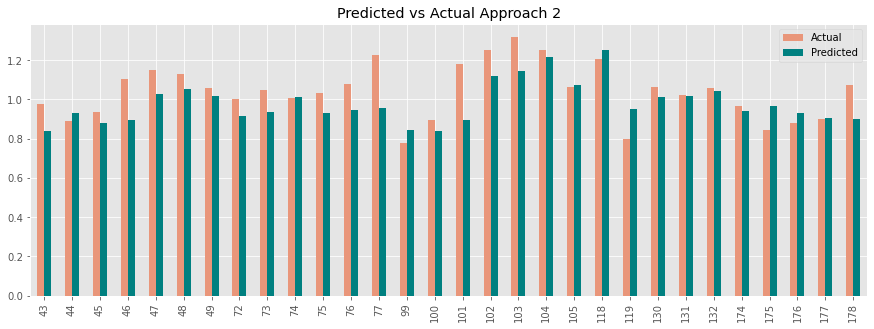

In [73]:
aux_plot_real_vs_pred(1, y_test_appch2_clean, y_pred_2_hist)

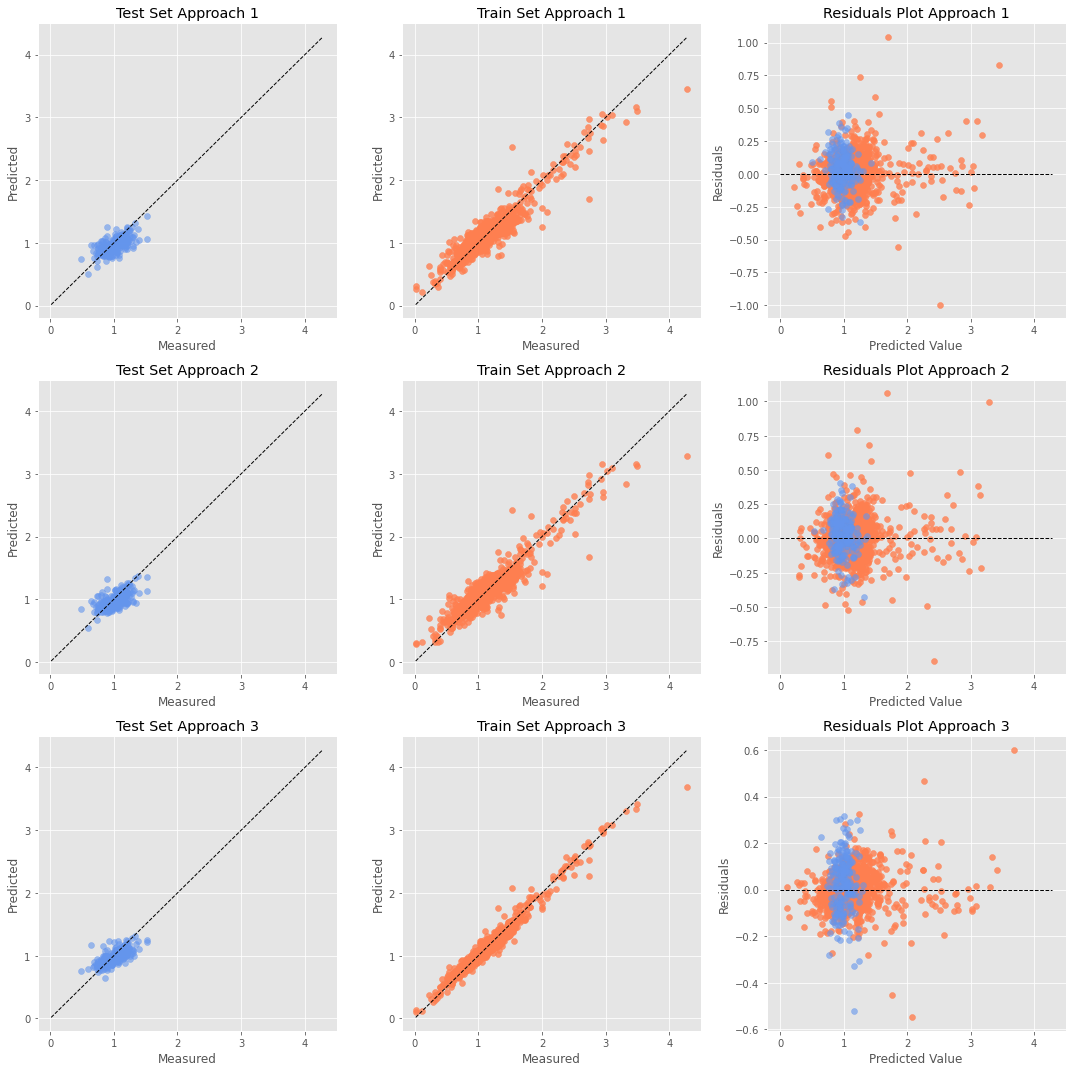

In [74]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

plot_aux(0, y_test_appch1_clean, y_pred_1_hist, y_train_appch1_clean, y_pred_train_1_hist, ax)
plot_aux(1, y_test_appch2_clean, y_pred_2_hist, y_train_appch2_clean, y_pred_train_2_hist, ax)
plot_aux(2, y_test_appch3_clean, y_pred_3_hist, y_train_appch3_clean, y_pred_train_3_hist, ax)

fig.tight_layout()
plt.show()

### Shap Values 

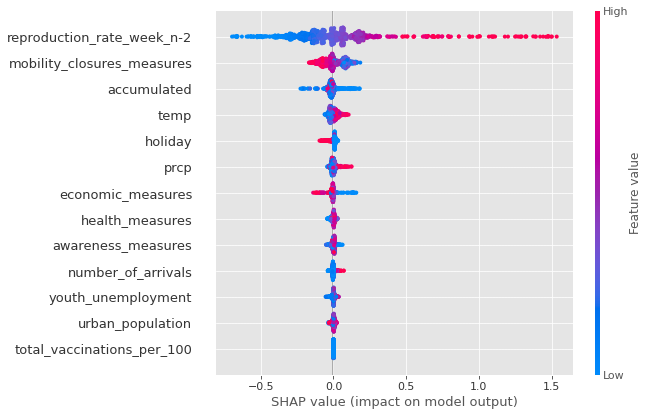

In [75]:
shap_values = shap.TreeExplainer(reg2_hist).shap_values(X_train_appch2_clean)
shap.summary_plot(shap_values, X_train_appch2_clean)

In [76]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train_appch2.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance['percentage_change']= 100*feature_importance['feature_importance_vals']/y_train_appch2.mean()
feature_importance

col_name  feature_importance_vals  percentage_change
12  reproduction_rate_week_n-2                 0.217426          18.890726
2   mobility_closures_measures                 0.059599           5.178153
11                 accumulated                 0.027115           2.355804
5                         temp                 0.021020           1.826266
4                      holiday                 0.013362           1.160966
6                         prcp                 0.012613           1.095835
3            economic_measures                 0.011864           1.030743
1              health_measures                 0.008390           0.728975
0           awareness_measures                 0.008214           0.713642
7           number_of_arrivals                 0.006737           0.585356
10          youth_unemployment                 0.006682           0.580554
8             urban_population                 0.005961           0.517906
9   total_vaccinations_per_100                 0.000000           0.000000

* SHAP values represented above seem to follow good logic and explainability. Although there are some measures that do not follow a proper logic based on evidence. Overall we will find this model as a candidate in terms of interpretability.
* However some features seem to have very low importance, remarkable low value of awareness measures and health measures.
* Temperature has different sign from other shap values evaluation in methodology with no lag values.
* Results in terms of metrics seem to have improved from methodology without lagged values [03_data_model_evaluation.ipynb](https://github.com/lucasbotellaroca/Covid-19_Reproduction_Rate_Estimator/blob/main/notebooks/03_data_model_evaluation.ipynb)

## NuSVR<a name="nusvr"></a>

In [77]:
from sklearn.svm import NuSVR
reg1_nusvr = NuSVR(C=1.0, nu=0.1)
reg2_nusvr = NuSVR(C=1.0, nu=0.1)
reg3_nusvr = NuSVR(C=1.0, nu=0.1)

reg1_nusvr.fit(X_train_appch1_clean, y_train_appch1_clean)
reg2_nusvr.fit(X_train_appch2_clean, y_train_appch2_clean)
reg3_nusvr.fit(X_train_appch3_clean, y_train_appch3_clean)

y_pred_1_nusvr=reg1_nusvr.predict(X_test_appch1_clean)
y_pred_train_1_nusvr=reg1_nusvr.predict(X_train_appch1_clean)
y_pred_2_nusvr=reg2_nusvr.predict(X_test_appch2_clean)
y_pred_train_2_nusvr=reg2_nusvr.predict(X_train_appch2_clean)
y_pred_3_nusvr=reg3_nusvr.predict(X_test_appch3_clean)
y_pred_train_3_nusvr=reg3_nusvr.predict(X_train_appch3_clean)

### Evaluation

#### Test Set

In [78]:
df_scores_NuSVR=get_metrics_data_frame(y_test_appch1_clean,y_pred_1_nusvr, y_test_appch2_clean, y_pred_2_nusvr,y_test_appch3_clean, y_pred_3_nusvr)
df_eval_approach_2.loc['NuSVR'] = df_scores_NuSVR.loc['Approach 2']
highlight_min(df_scores_NuSVR)

#### Train Set

In [79]:
df_scores_NuSVR_train=get_metrics_data_frame(y_train_appch1_clean,y_pred_train_1_nusvr, y_train_appch2_clean, y_pred_train_2_nusvr,y_train_appch3_clean, y_pred_train_3_nusvr)
highlight_min(df_scores_NuSVR_train)

## Results View

#### Actual vs Predicted

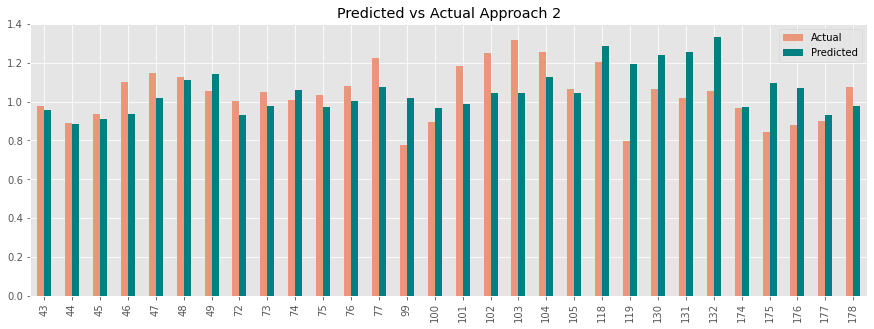

In [80]:
aux_plot_real_vs_pred(1, y_test_appch2_clean, y_pred_2_nusvr)

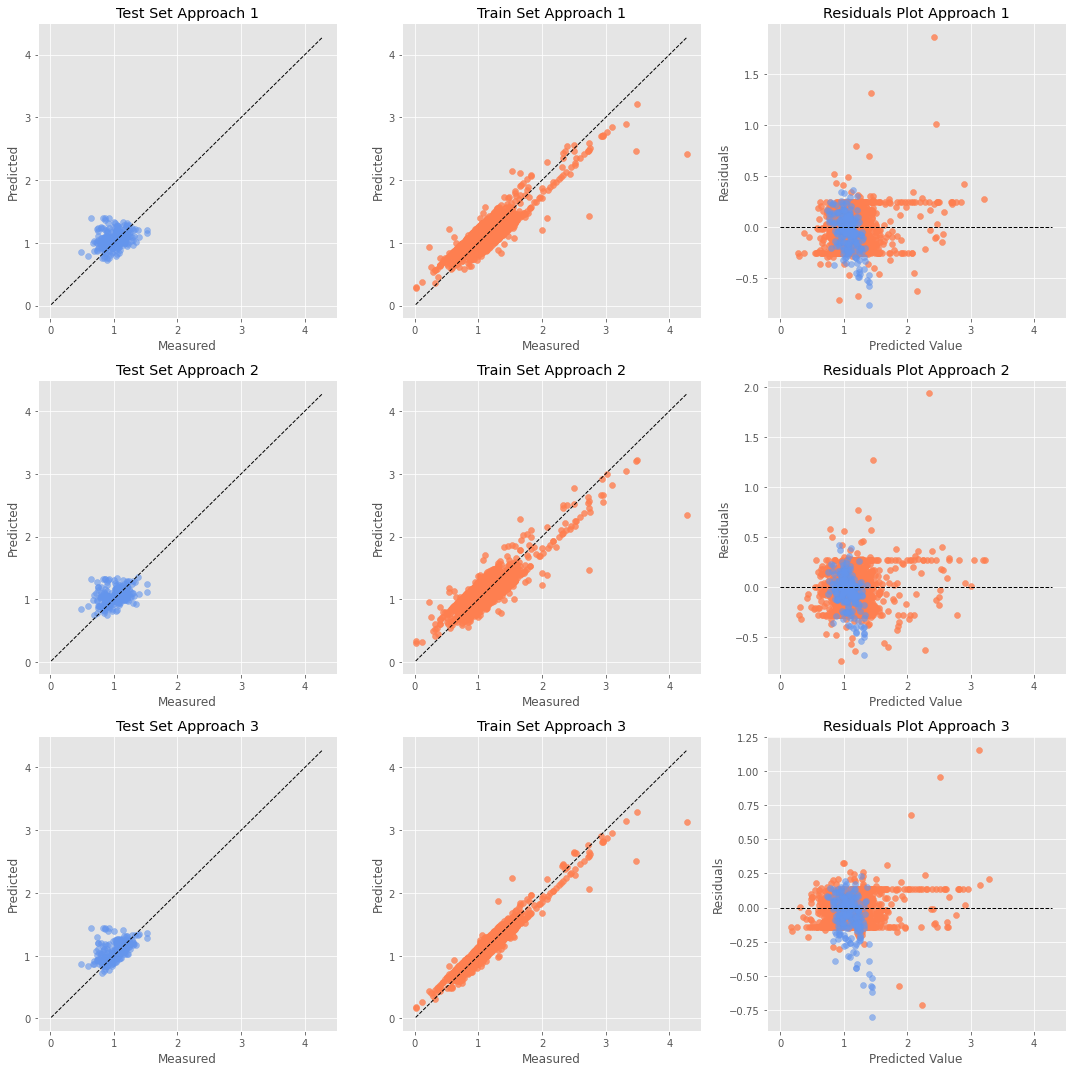

In [81]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

plot_aux(0, y_test_appch1_clean, y_pred_1_nusvr, y_train_appch1_clean, y_pred_train_1_nusvr, ax)
plot_aux(1, y_test_appch2_clean, y_pred_2_nusvr, y_train_appch2_clean, y_pred_train_2_nusvr, ax)
plot_aux(2, y_test_appch3_clean, y_pred_3_nusvr, y_train_appch3_clean, y_pred_train_3_nusvr, ax)

fig.tight_layout()
plt.show()

### Shap Values 

In [82]:
#shap_values = shap.TreeExplainer(reg2_knn).shap_values(X_train_appch2_clean)
#shap.summary_plot(shap_values, X_train_appch2_clean)

* Not suported for NuSVR

* As seen Approach 2 together with Approach 1 seems to be getting the best result in the test set and is the one getting the best fit to the predicted-measured line.
* Approach 3 seems to be getting bad results. 
* However this model seems to be getting **worse results than XGB, LGBM, Gradient Boosting and Histogram Gradient Boosting**, we will analyze this in further detail later on. 
* Overall estimations seem to be very bad.
* It is also important to note that the **test set has a smaller range of values (0.5, 1.5) than the train set (0, 4.5)** and its concentration and variance is higher.
* There are no signs of overfitting based on the plots shown together with the analysis in the residuals plot.

[Up](#table_of_contents)
## Comparing Three Models with Three Approaches<a name="comp"></a>
Once we have an intuition and individual evaluation of each model we will look at all models with the three different approaches in order to asses best and worse results, and which approach seems to be the best. 

In [83]:
xgb_mae, lgb_mae, gbst_mae, knn_mae, hist_mae, NuSVR_mae = get_values_metric('mae')
xgb_mse, lgb_mse, gbst_mse, knn_mse, hist_mae, NuSVR_mae = get_values_metric('mse')
xgb_rmse, lgb_rmse, gbst_rmse, knn_rmse, hist_mae, NuSVR_mae = get_values_metric('rmse')
xgb_mape, lgb_mape, gbst_mape, knn_mape, hist_mae, NuSVR_mae = get_values_metric('mape')

xgb_mae=xgb_mae.sort_index(ascending=False)
lgb_mae=lgb_mae.sort_index(ascending=False)
gbst_mae=gbst_mae.sort_index(ascending=False)
knn_mae=knn_mae.sort_index(ascending=False)
hist_mae=knn_mae.sort_index(ascending=False)
NuSVR_mae=knn_mae.sort_index(ascending=False)

xgb_mse=xgb_mse.sort_index(ascending=False)
lgb_mse=lgb_mse.sort_index(ascending=False)
gbst_mse=gbst_mse.sort_index(ascending=False)
knn_mse=knn_mse.sort_index(ascending=False)
hist_mse=knn_mse.sort_index(ascending=False)
NuSVR_mse=knn_mse.sort_index(ascending=False)

xgb_rmse=xgb_rmse.sort_index(ascending=False)
lgb_rmse=lgb_rmse.sort_index(ascending=False)
gbst_rmse=gbst_rmse.sort_index(ascending=False)
knn_rmse=knn_rmse.sort_index(ascending=False)
hist_rmse=knn_rmse.sort_index(ascending=False)
NuSVR_rmse=knn_rmse.sort_index(ascending=False)

xgb_mape=xgb_mape.sort_index(ascending=False)
lgb_mape=lgb_mape.sort_index(ascending=False)
gbst_mape=gbst_mape.sort_index(ascending=False)
knn_mape=knn_mape.sort_index(ascending=False)
hist_mape=knn_mape.sort_index(ascending=False)
NuSVR_mape=knn_mape.sort_index(ascending=False)

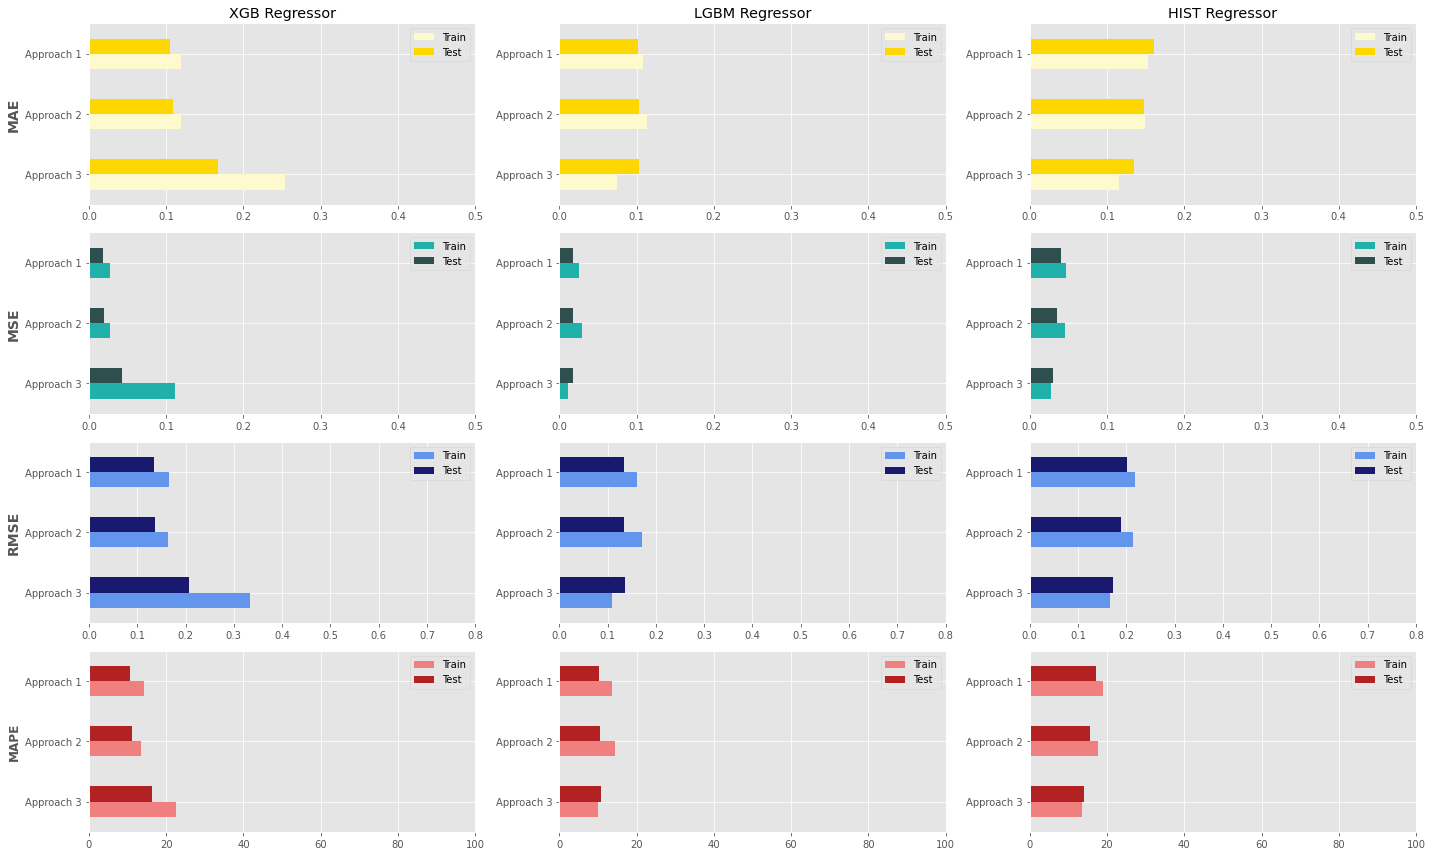

In [84]:
fig, ax = plt.subplots(4,3,figsize=(20,12))

xgb_mae.plot.barh(ax=ax[0][0], color=["lemonchiffon","gold"],title = 'XGB Regressor').set_ylabel('MAE', fontsize=14.0, fontweight='bold')
lgb_mae.plot.barh(ax=ax[0][1], color=["lemonchiffon","gold"],title = 'LGBM Regressor')
hist_mae.plot.barh(ax=ax[0][2], color=["lemonchiffon","gold"],title = 'HIST Regressor')
xgb_mse.plot.barh(ax=ax[1][0], color=["lightseagreen","darkslategray"]).set_ylabel('MSE', fontsize=14.0, fontweight='bold')
lgb_mse.plot.barh(ax=ax[1][1], color=["lightseagreen","darkslategray"])
hist_mse.plot.barh(ax=ax[1][2], color=["lightseagreen","darkslategray"])
xgb_rmse.plot.barh(ax=ax[2][0], color=["cornflowerblue","midnightblue"]).set_ylabel('RMSE', fontsize=14.0, fontweight='bold')
lgb_rmse.plot.barh(ax=ax[2][1], color=["cornflowerblue","midnightblue"])
hist_rmse.plot.barh(ax=ax[2][2], color=["cornflowerblue","midnightblue"])
xgb_mape.plot.barh(ax=ax[3][0], color=["lightcoral","firebrick"]).set_ylabel('MAPE',fontsize=12.0, fontweight='bold')
lgb_mape.plot.barh(ax=ax[3][1], color=["lightcoral","firebrick"])
hist_mape.plot.barh(ax=ax[3][2], color=["lightcoral","firebrick"])

ax[0][0].set_xlim([0, 0.5])
ax[0][1].set_xlim([0, 0.5])
ax[0][2].set_xlim([0, 0.5])

ax[1][0].set_xlim([0, 0.5])
ax[1][1].set_xlim([0, 0.5])
ax[1][2].set_xlim([0, 0.5])

ax[2][0].set_xlim([0, 0.8])
ax[2][1].set_xlim([0, 0.8])
ax[2][2].set_xlim([0, 0.8])

ax[3][0].set_xlim([0, 100])
ax[3][1].set_xlim([0, 100])
ax[3][2].set_xlim([0, 100])

fig.tight_layout()

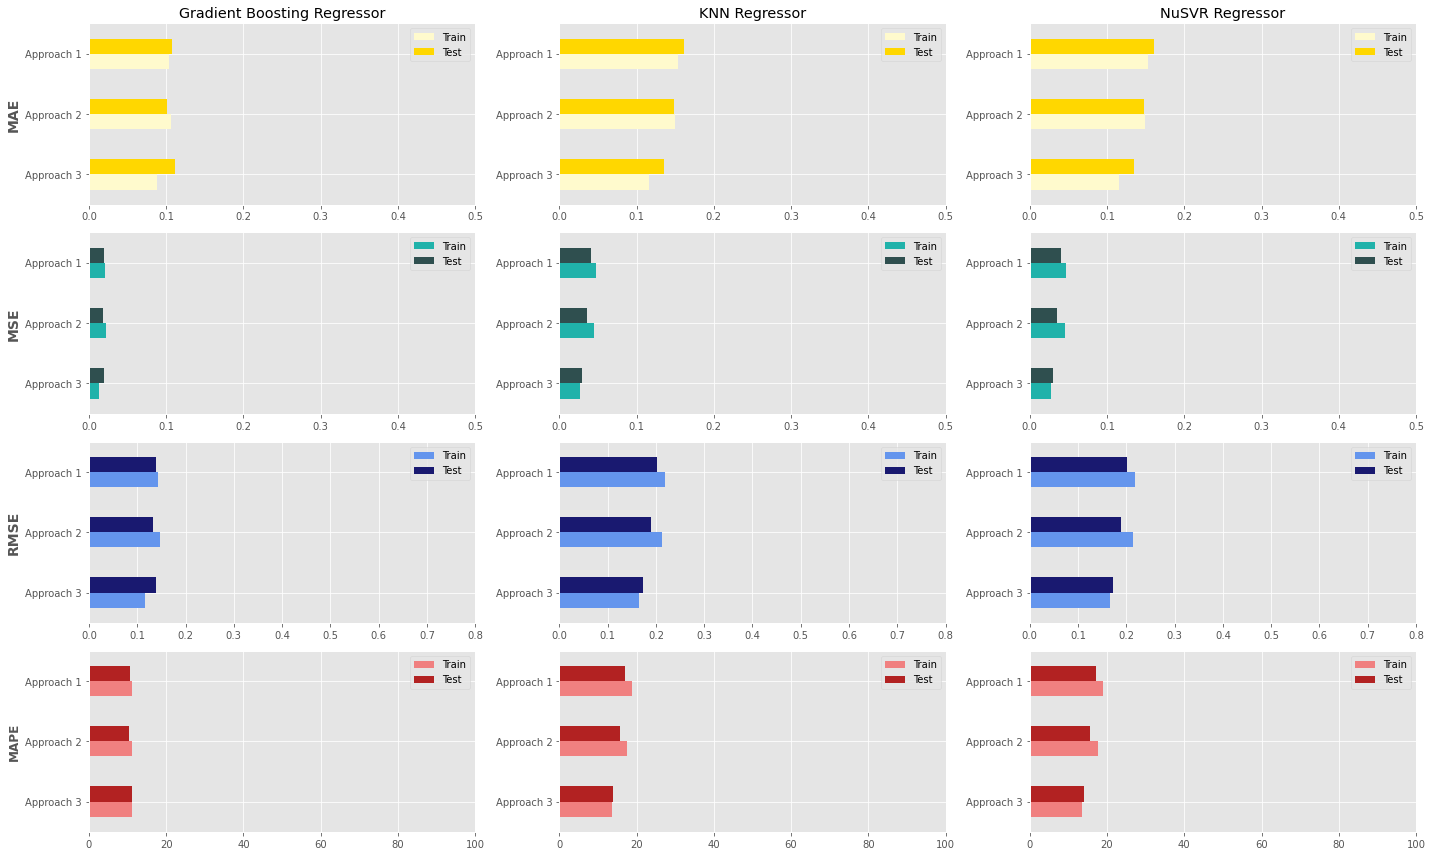

In [85]:
fig, ax = plt.subplots(4,3,figsize=(20,12))

gbst_mae.plot.barh(ax=ax[0][0], color=["lemonchiffon","gold"],title = 'Gradient Boosting Regressor').set_ylabel('MAE', fontsize=14.0, fontweight='bold')
knn_mae.plot.barh(ax=ax[0][1], color=["lemonchiffon","gold"],title = 'KNN Regressor')
NuSVR_mae.plot.barh(ax=ax[0][2], color=["lemonchiffon","gold"],title = 'NuSVR Regressor')
gbst_mse.plot.barh(ax=ax[1][0], color=["lightseagreen","darkslategray"]).set_ylabel('MSE', fontsize=14.0, fontweight='bold')
knn_mse.plot.barh(ax=ax[1][1], color=["lightseagreen","darkslategray"])
NuSVR_mse.plot.barh(ax=ax[1][2], color=["lightseagreen","darkslategray"])
gbst_rmse.plot.barh(ax=ax[2][0], color=["cornflowerblue","midnightblue"]).set_ylabel('RMSE', fontsize=14.0, fontweight='bold')
knn_rmse.plot.barh(ax=ax[2][1], color=["cornflowerblue","midnightblue"])
NuSVR_rmse.plot.barh(ax=ax[2][2], color=["cornflowerblue","midnightblue"])
gbst_mape.plot.barh(ax=ax[3][0], color=["lightcoral","firebrick"]).set_ylabel('MAPE',fontsize=12.0, fontweight='bold')
knn_mape.plot.barh(ax=ax[3][1], color=["lightcoral","firebrick"])
NuSVR_mape.plot.barh(ax=ax[3][2], color=["lightcoral","firebrick"])

ax[0][0].set_xlim([0, 0.5])
ax[0][1].set_xlim([0, 0.5])
ax[0][2].set_xlim([0, 0.5])

ax[1][0].set_xlim([0, 0.5])
ax[1][1].set_xlim([0, 0.5])
ax[1][2].set_xlim([0, 0.5])

ax[2][0].set_xlim([0, 0.8])
ax[2][1].set_xlim([0, 0.8])
ax[2][2].set_xlim([0, 0.8])

ax[3][0].set_xlim([0, 100])
ax[3][1].set_xlim([0, 100])
ax[3][2].set_xlim([0, 100])

fig.tight_layout()

* In conclusion, Approaches 1 and 2 seem to be getting the best results for all  six models.
* There are no signs of overfitting based on the metrics and residual plots visualized.
* Boosting models **(XGB, LGBM, Gradient boosting and Histogram Gradient Boosting)** seem to be getting the best results based on the fits and metrics observed.
* Results seem to have improved from methodology without lagged values [03_data_model_evaluation.ipynb](https://github.com/lucasbotellaroca/Covid-19_Reproduction_Rate_Estimator/blob/main/notebooks/03_data_model_evaluation.ipynb)

[Up](#table_of_contents)
# Phase 2<a name="phase_2"></a>
* Evaluate every model in depth with the selected approach and select best models for our approach. Overview of results of approach 2 with selected models in order to perform in detail analysis in phase 3, therefore, best models will be used in phase 3.

## Evaluating Results for Approach 2<a name="eval_appch2_2"></a>
It has been stated that approaches 1 and 2 seem to be getting simillar results, and that approach 3 is getting best results among three approaches. However, the fact that approach 2 is simpler and easier to understand in further analysis of SHAP values, and the importance of each future selected **we will select Approach 2** as mentioned before for our final model. Approach 2 has less variables but with more significance overall.

* As mentioned, approach 2 seems to be the most replicable and explainable model, therefore we will work with this model. 
* We will look at the metrics mae, mse, rmse and mape of all regressor used and compare them visually.

Text(0.5, 1.0, 'MAPE')

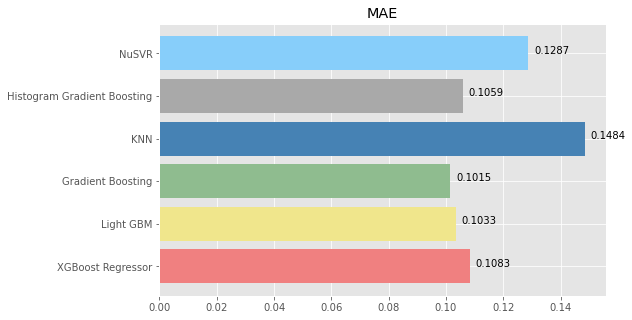

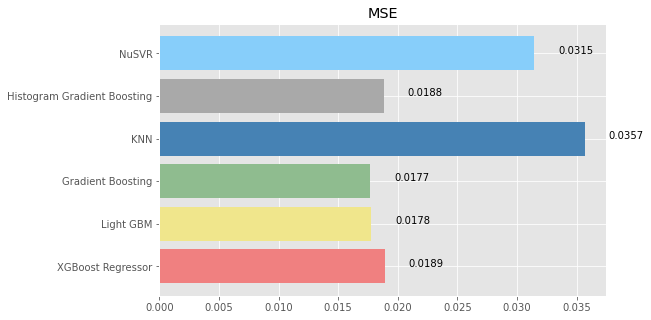

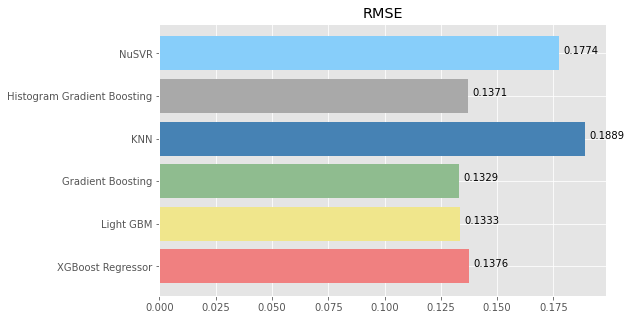

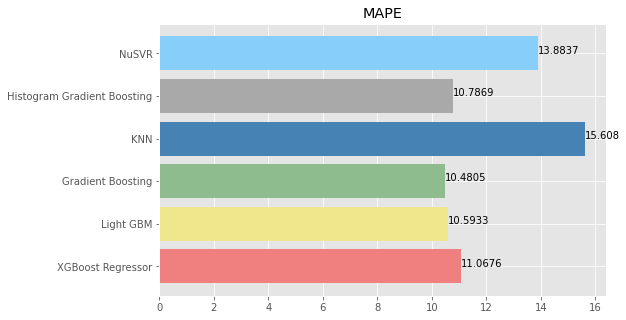

In [86]:
colors = ['lightcoral', 'khaki', 'darkseagreen', 'steelblue', 'darkgray', 'lightskyblue']
y=np.round(df_eval_approach_2['mae'], decimals=4)

fig, ax = plt.subplots(figsize=(8, 5)) 
ind=np.arange(len(df_eval_approach_2))
ax.barh(ind, df_eval_approach_2['mae'], color=colors)
plt.yticks(ind,df_eval_approach_2.index.tolist())

for i, v in enumerate(y):
    ax.text(v+0.002, i, str(v), color='black')
ax.set_title('MAE')

y=np.round(df_eval_approach_2['mse'], decimals=4)

fig, ax = plt.subplots(figsize=(8, 5)) 
ind=np.arange(len(df_eval_approach_2))
ax.barh(ind, df_eval_approach_2['mse'], color=colors)
plt.yticks(ind,df_eval_approach_2.index.tolist())

for i, v in enumerate(y):
    ax.text(v+0.002, i, str(v), color='black')
ax.set_title('MSE')

y=np.round(df_eval_approach_2['rmse'], decimals=4)

fig, ax = plt.subplots(figsize=(8, 5)) 
ind=np.arange(len(df_eval_approach_2))
ax.barh(ind, df_eval_approach_2['rmse'], color=colors)
plt.yticks(ind,df_eval_approach_2.index.tolist())

for i, v in enumerate(y):
    ax.text(v+0.002, i, str(v), color='black')
ax.set_title('RMSE')

y=np.round(df_eval_approach_2['mape'], decimals=4)

fig, ax = plt.subplots(figsize=(8, 5)) 
ind=np.arange(len(df_eval_approach_2))
ax.barh(ind, df_eval_approach_2['mape'], color=colors)
plt.yticks(ind,df_eval_approach_2.index.tolist())

for i, v in enumerate(y):
    ax.text(v+0.002, i, str(v), color='black')
ax.set_title('MAPE')

Based on the metrics shown  it can be seen taht XGB, **LGBM, Gradient boosting and Histogram Gradient Boosting** are getting the best results, we will perform in detail analysis to them.

[Up](#table_of_contents)
# Time Series Split Evaluation Approach 2<a name="t_series"></a>
We decide to zoom in our predictions on the **test set range (0.5, 1.5)** in order to better visualizes fits of the models.

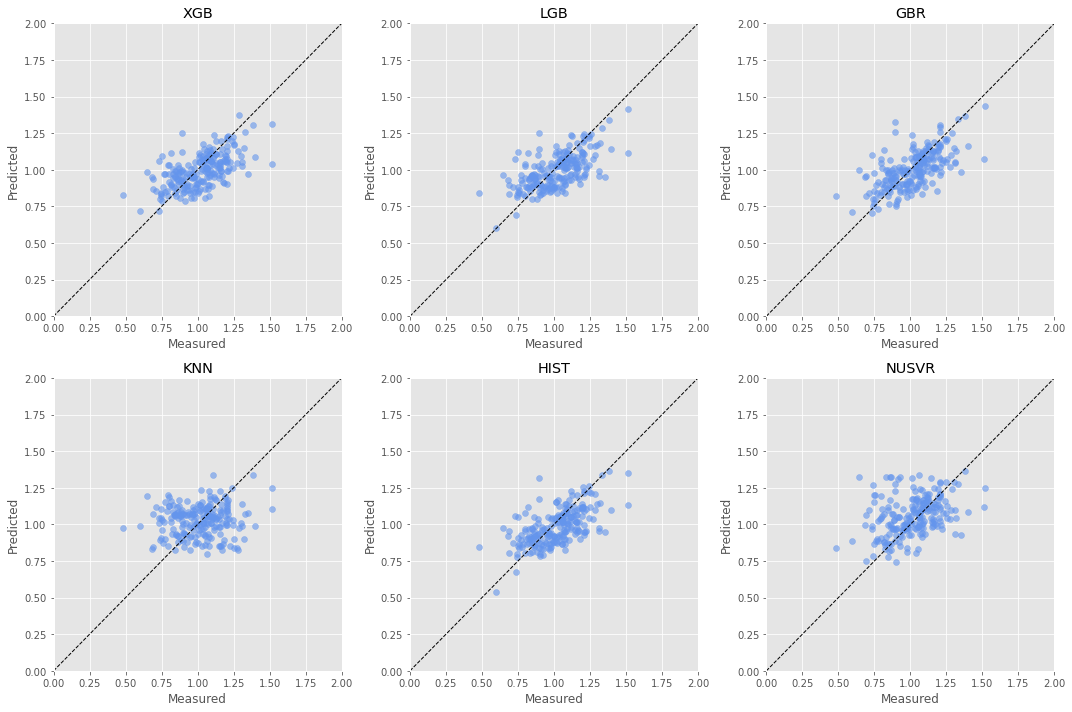

In [87]:
fig, ax = plt.subplots(2,3,figsize=(15,10))

aux_plot_3('XGB', 0,0, y_test_appch2, y_pred_2_xgb, y_train_appch2, ax)
aux_plot_3('LGB', 0,1, y_test_appch2, y_pred_2_lgb, y_train_appch2, ax)
aux_plot_3('GBR', 0,2, y_test_appch2, y_pred_2_gbr, y_train_appch2, ax)
aux_plot_3('KNN', 1,0, y_test_appch2, y_pred_2_knn, y_train_appch2, ax)
aux_plot_3('HIST', 1,1, y_test_appch2, y_pred_2_hist, y_train_appch2, ax)
aux_plot_3('NUSVR', 1,2, y_test_appch2, y_pred_2_nusvr, y_train_appch2, ax)

fig.tight_layout()

It can be seen that the best approaches seem the ones obtained by the metrics. We will perform time series evaluation on the selected models.
* Results seem to have improved from methodology without lagged values [03_data_model_evaluation.ipynb](https://github.com/lucasbotellaroca/Covid-19_Reproduction_Rate_Estimator/blob/main/notebooks/03_data_model_evaluation.ipynb)
* We will perform 6 splits, with the selected top models, and compare them.

### Assessing the R2 mismatch between train and test<a name="r2_mismatch"></a>
As seen in the predictions for the initial split of 2020 (train) 2021 (test) it can be seen that R2 socre highglydiffers for all three approaches in all models. However there is no sign of overfitting. So in order to understand this we will try to understand the R2 formula first and secondly evaluate what is happening with out train vs our dataset.

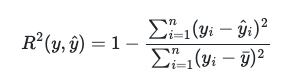

As seen on the right term of R2 there is a coefficient which in the denominator contains the equivalent to the sum of maes squared and on the denominator it contains the sum of the variance squared, the variance is divided by N, but this is a fixed term therefore it does not imply changes in the following analysis.

The main idea is that if the variance in both test and train are the same, then any changes in the value of R2 will mean that there is a difference in the predictions in train and test. In case of the mae been equivalent, therefore the predictions staying the same, it will be due to a difference in the variance of train ind test sets, which is our specific case. **R2 score is so different in train and test because the variation of values in train and test are widely different**.

In order to explain this lets just look at variance in test and train for the previous evaluation:


In [88]:
np.var(y_train_appch2), np.var(y_test_appch2)

(0.18117963507841053, 0.02852503598799875)

As seen, variance in the trainset is 0.169 and variance in the test set is 0.051. This is a significant difference actually, it is 0.169/0.051=**5.86 times greater**

And this is the cause why our R2 score is so different in train and test, and this will be more appreciated in the later analysis when performing folds.

The reason behind this is that **governments are able to apply measures and restrictions in order to fit the desired reproduction rate of 1**, which by looking at the data seems to be the intention of governemnts worldwide. That has been appreciated in the plots as well, values **ranging from (0.0, 4)** for 2021 and values **ranging from (0.5, 1.5) in 2021**

We will assess the mentioned result and evaluation in the end of this notebook when we will analyze the validation and validation of the studied models.

[Up](#table_of_contents)
# Phase 3<a name="phase_3"></a>
* Perform in detail time series split (multiple splits) with selected approach and narrowed filtered models from point 2. Select best model for selected approach and evaluate results. Perform in detail analysis using time series split on best models for selected approach.

## Time Series Train Test Split for XGB, LGBM, Gradient Boosting and Histogram Gradient Boosting<a name="alleval"></a>
* Once the mistmatch in R2 has been stated, let´s look at our evaluation of each model based on the time series train test split. 


* Based on observed testing and iterances it has been decided to evaluate it as time series split wise but with a little modification, based on the refered article (https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8)


* Traditional time series split provided by sklearn **starts with a small portion of the dataset**, therefore, the first iterations in our folding have some bad results, since the model needs a minimum amount of data in order to extract meaningful estimated values. Therefore we have created a **custom auxiliary function *time_test_split_custom(model)*** that given a model perform time series evaluation from an start date determined. In our case it is the first 1000 rows which is equivalent to September 2020, therefore minimum training dataset contains data from March 2020 till September 2020, and such dataset start being larger in every fold of the 6 folds performed.


In [89]:
# Sort values by Date in order for the split to work
df_time=df_appch2.copy()
df_time=df_time.sort_values('Date').reset_index()

df_time_clean=df_appch2_clean.copy()
df_time_clean=df_time_clean.sort_values('Date').reset_index()

### XGB Regressor<a name="xgb_2"></a>
* Parameter selection based on train and error minimization approximation. First approach using Grid Search Cv in previous analysis was resulting in overfitting, therefore cutting number of estimators down to 10 for our case.

[09:07:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { early_stopping_rounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:07:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { early_stopping_rounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:07:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { early_stopping_rounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down

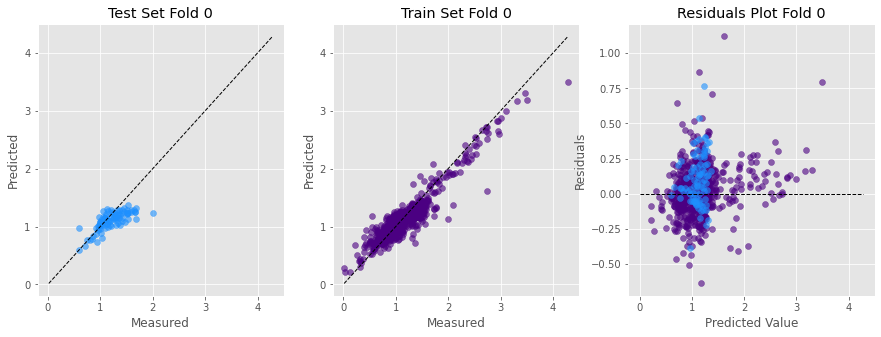

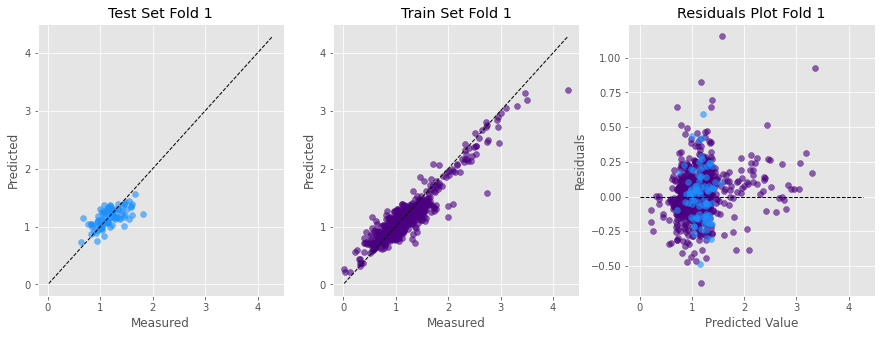

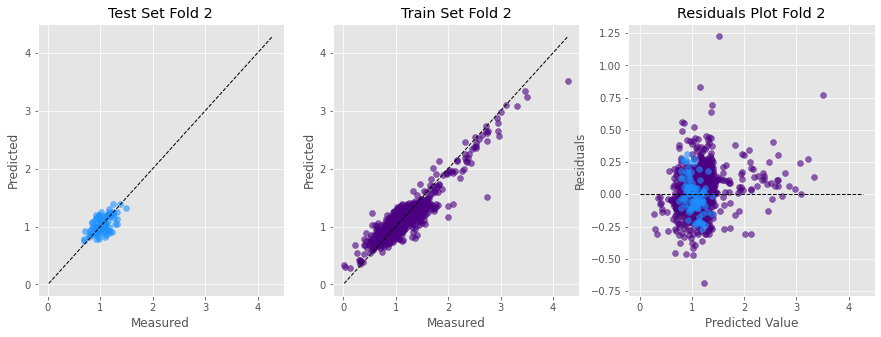

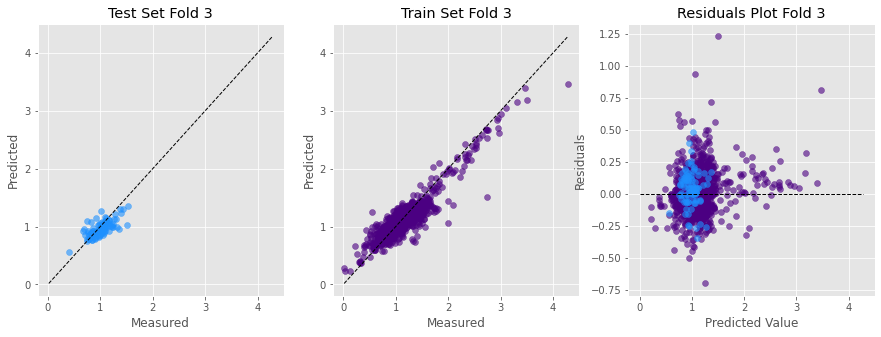

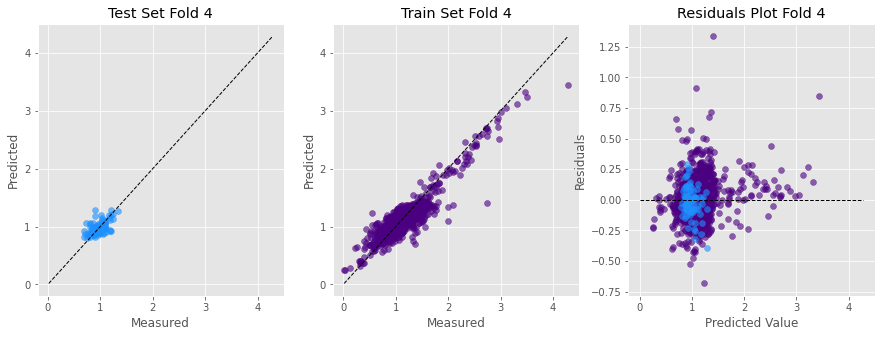

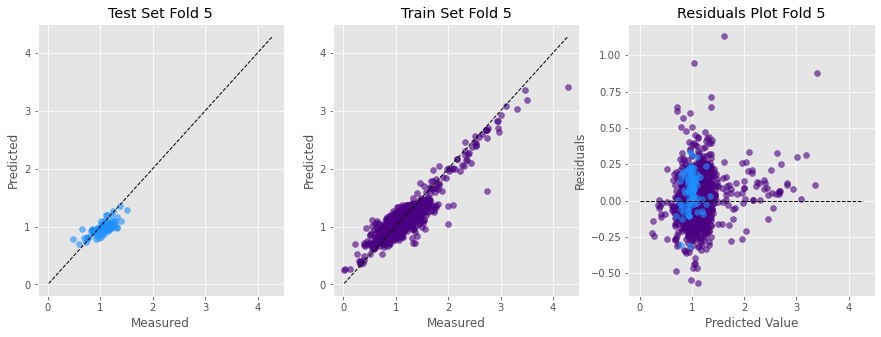

In [90]:
model_xgb = XGBRegressor(max_depth=4,early_stopping_rounds=3, n_estimators=10, silent=1)
df_xgb_met=time_test_split_custom(model_xgb, df_time)

In [91]:
print('Average Test Mape: ' + str(df_xgb_met['mape'].mean()))
print('Average Test Mse: ' + str(df_xgb_met['mse'].mean()))
print('Average Test Mae: ' + str(df_xgb_met['mae'].mean()))

cm = sns.light_palette("green", as_cmap=True)
s = df_xgb_met.style.background_gradient(cmap=cm, subset=['var_test', 'var_train'])
s

Average Test Mape: 11.235000763842757
Average Test Mse: 0.025045570515323686
Average Test Mae: 0.12088728527770187


* Metrcis seem to be getting simillar results in all folds.
* As seen variance in train set is much larger as therefore returning bad values of R2 in the test set due to difference in variance.

### LGBM Regressor<a name="lgbm_2"></a>
* Hiperparameter selection based on gird search cv performed in first analysis.

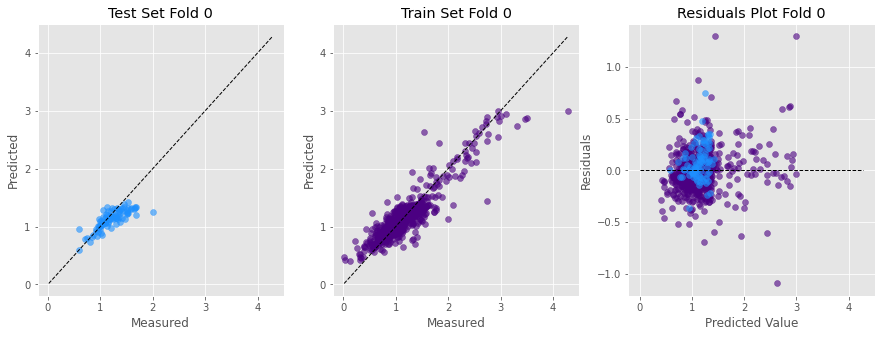

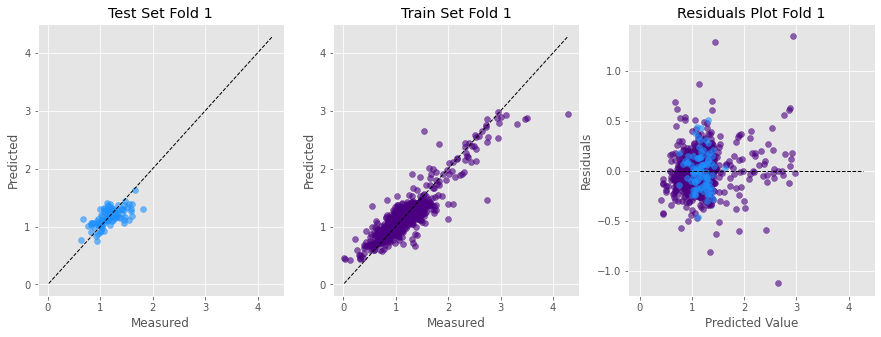

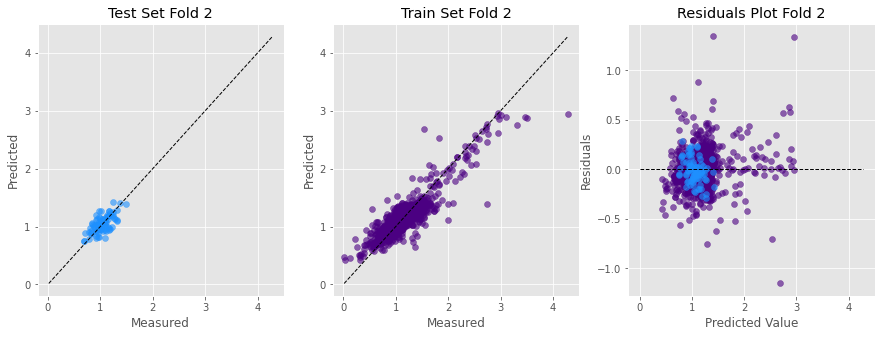

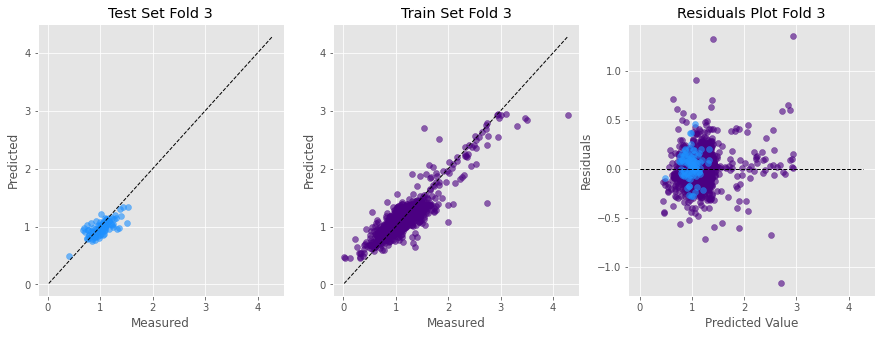

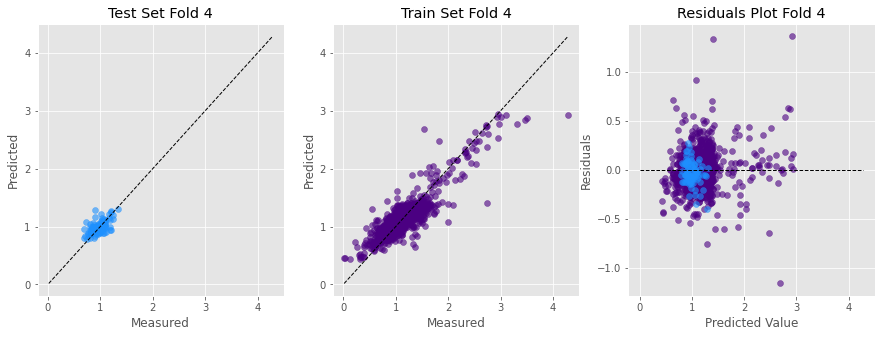

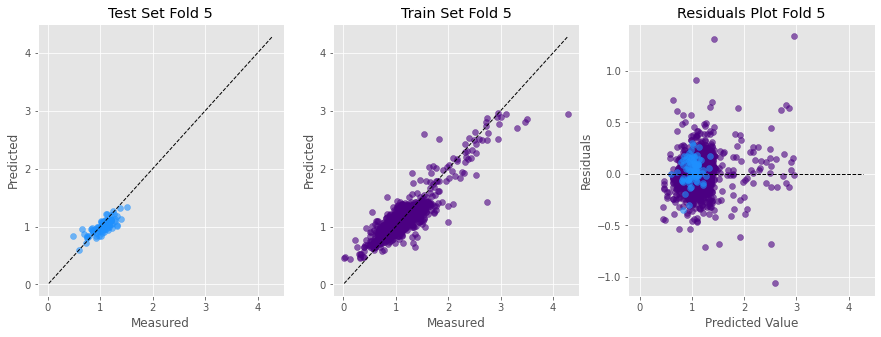

In [92]:
model_lgb=lgb.LGBMRegressor(max_depth=3, n_estimators=41)
df_lgb_met=time_test_split_custom(model_lgb,df_time)

In [93]:
print('Average Test Mape: ' + str(df_lgb_met['mape'].mean()))
print('Average Test Mse: ' + str(df_lgb_met['mse'].mean()))
print('Average Test Mae: ' + str(df_lgb_met['mae'].mean()))
cm = sns.light_palette("green", as_cmap=True)
s = df_lgb_met.style.background_gradient(cmap=cm, subset=['var_test', 'var_train'])
s

Average Test Mape: 10.497015775567002
Average Test Mse: 0.021632609470518
Average Test Mae: 0.11160438536628081


* Metrics to be getting the best results in last four iterations.
* As seen variance in train set is much larger as therefore returning bad values of R2 in the test set due to difference in variance.

### Gradient Boosting<a name="gbst_2"></a>
* Parameter selection based on train and error tunning. First approach used in previous analysis was resulting in overfitting.

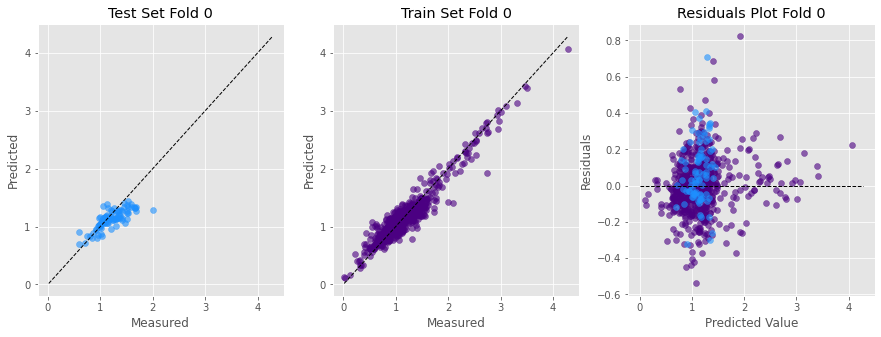

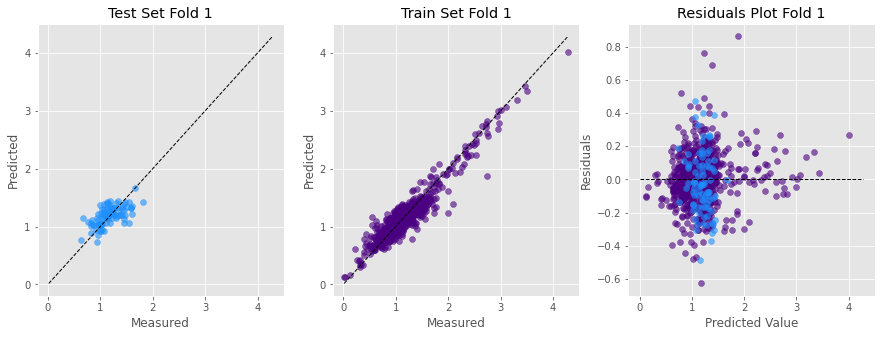

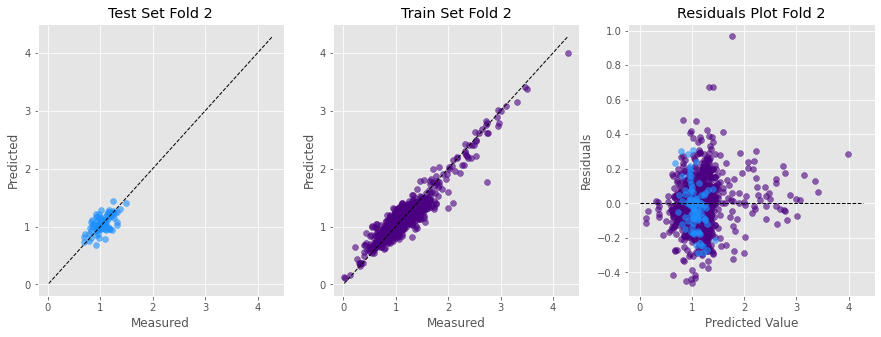

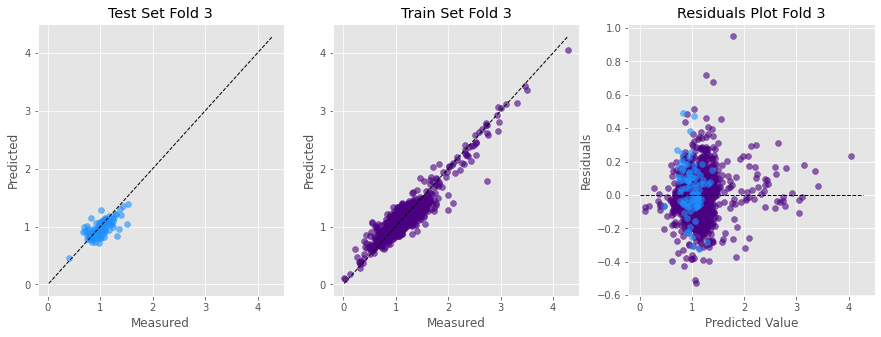

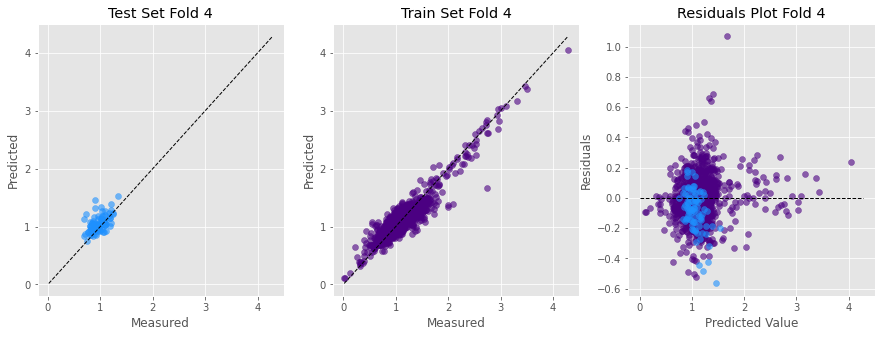

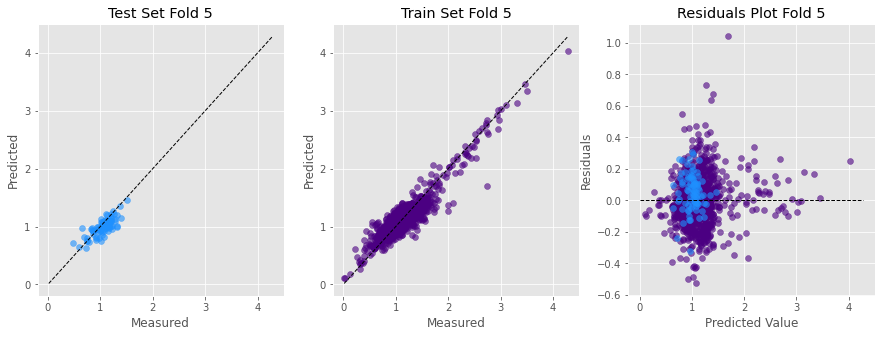

In [94]:
model_gbst=GradientBoostingRegressor(max_depth=3)
df_gbst_met=time_test_split_custom(model_gbst,df_time_clean)

In [95]:
print('Average Test Mape: ' + str(df_gbst_met['mape'].mean()))
print('Average Test Mse: ' + str(df_gbst_met['mse'].mean()))
print('Average Test Mae: ' + str(df_gbst_met['mae'].mean()))
cm = sns.light_palette("green", as_cmap=True)
s = df_gbst_met.style.background_gradient(cmap=cm, subset=['var_test', 'var_train'])
s

Average Test Mape: 11.590526855130946
Average Test Mse: 0.025434363165261598
Average Test Mae: 0.12180773504614574


* Mae and mape seem to be getting the best results in last four iterations.
* As seen variance in train set is much larger as therefore returning bad values of R2 in the test set due to difference in variance.

### Histogram Gradient Boosting<a name="hist_2"></a>
* Parameter selection based on first analysis.

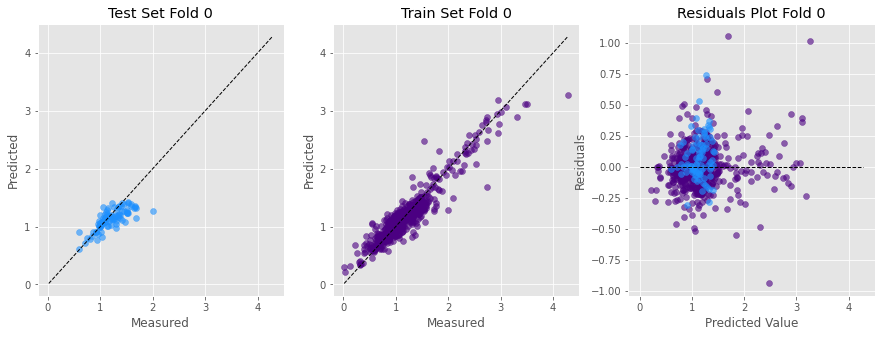

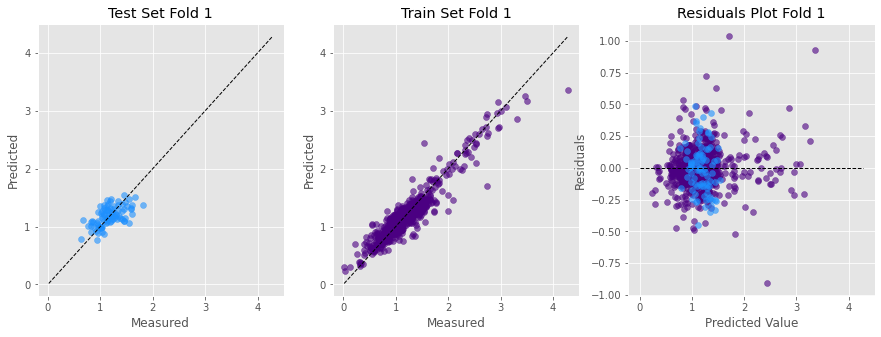

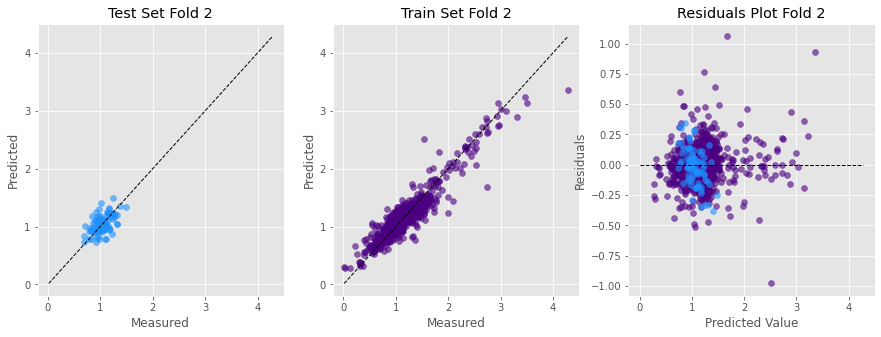

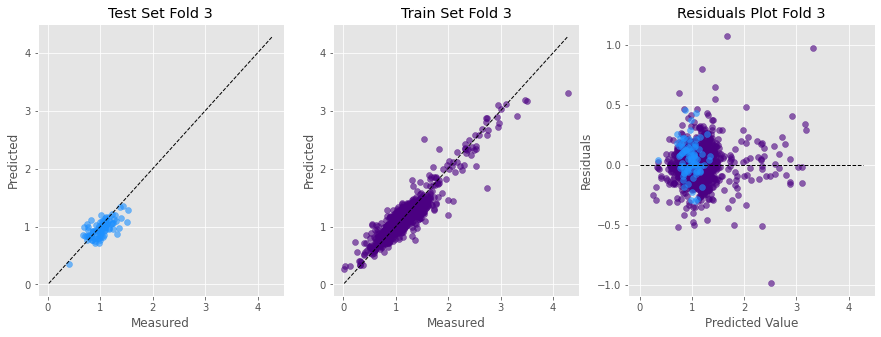

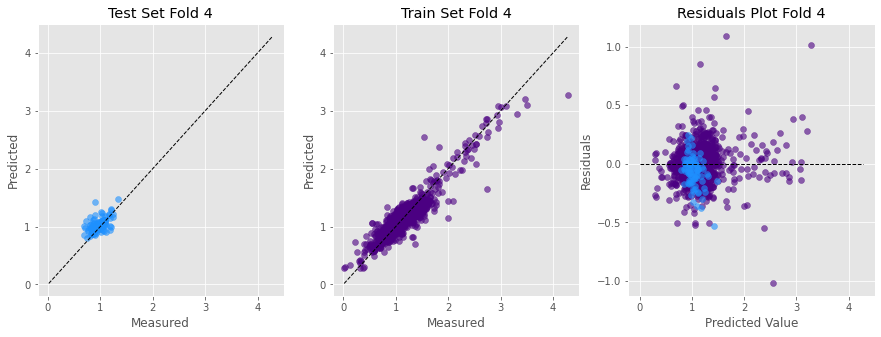

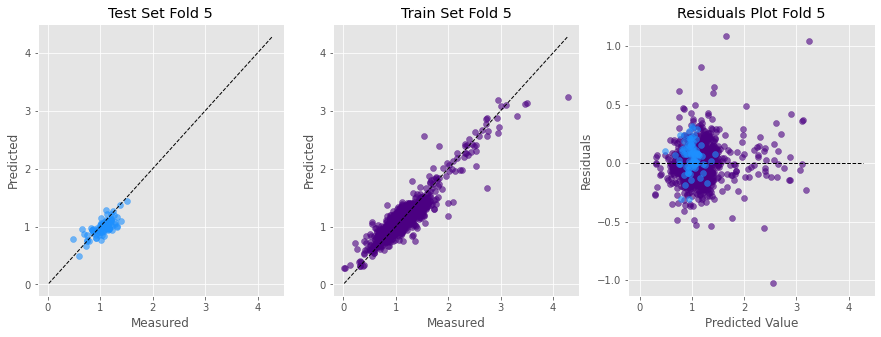

In [96]:
model_hist=HistGradientBoostingRegressor(max_depth=4)
df_hist_met=time_test_split_custom(model_hist,df_time_clean)

In [97]:
print('Average Test Mape: ' + str(df_hist_met['mape'].mean()))
print('Average Test Mse: ' + str(df_hist_met['mse'].mean()))
print('Average Test Mae: ' + str(df_hist_met['mae'].mean()))
cm = sns.light_palette("green", as_cmap=True)
s = df_hist_met.style.background_gradient(cmap=cm, subset=['var_test', 'var_train'])
s

Average Test Mape: 11.66073884397755
Average Test Mse: 0.02625310371914402
Average Test Mae: 0.1234708335201241


* Metrics seem to be getting the best results in last four iterations.
* As seen variance in train set is much larger as therefore returning bad values of R2 in the test set due to difference in variance.

[Up](#table_of_contents)
## Comparison of Time Series Train Test Split for XGB, LGBM, Gradient Boosting and Histogram Gradient Boosting<a name="comp_2"></a>

In [98]:
df_final_plot=pd.DataFrame(columns=['mae_xgb', 'mape_xgb', 'mae_lgb', 'mape_lgb',
                                    'mae_gbst', 'mape_gbst', 'mae_hist', 'mape_hist'])
df_final_plot['mae_xgb']=df_xgb_met['mae']
df_final_plot['mse_xgb']=df_xgb_met['mse']
df_final_plot['mape_xgb']=df_xgb_met['mape']
df_final_plot['mae_lgb']=df_lgb_met['mae']
df_final_plot['mse_lgb']=df_lgb_met['mse']
df_final_plot['mape_lgb']=df_lgb_met['mape']
df_final_plot['mae_gbst']=df_gbst_met['mae']
df_final_plot['mse_gbst']=df_gbst_met['mse']
df_final_plot['mape_gbst']=df_gbst_met['mape']
df_final_plot['mae_hist']=df_hist_met['mae']
df_final_plot['mse_hist']=df_hist_met['mse']
df_final_plot['mape_hist']=df_hist_met['mape']

### MAE

In [99]:
df_final_plot[[col for col in df_final_plot.columns if "mae" in col]].style.highlight_min(color = 'lightgreen', axis = 1)

Text(0.5, 0, 'Folds')

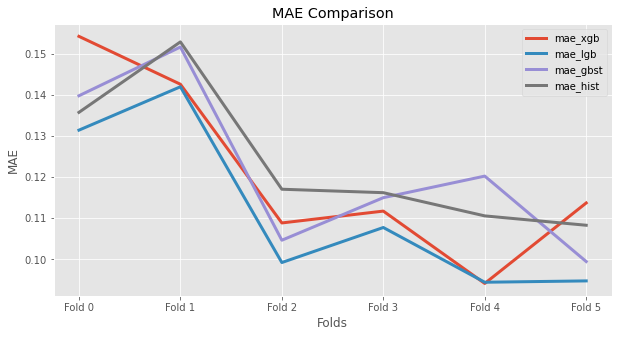

In [100]:
plt.rcParams["figure.figsize"] = (10,5)
df_final_plot[['mae_xgb', 'mae_lgb', 'mae_gbst', 'mae_hist']].plot(title='MAE Comparison', linewidth = 3)
plt.ylabel('MAE')
plt.xlabel('Folds')

### MSE

In [101]:
df_final_plot[[col for col in df_final_plot.columns if "mse" in col]].style.highlight_min(color = 'lightgreen', axis = 1)

Text(0.5, 0, 'Folds')

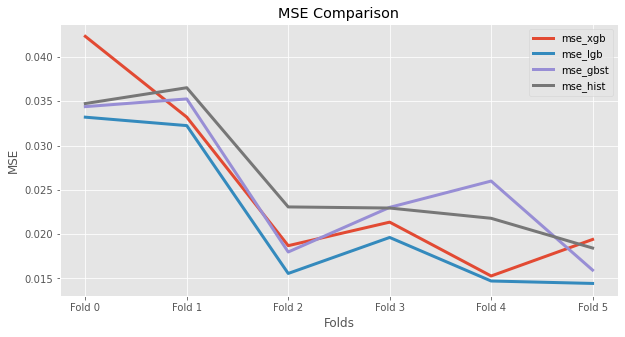

In [102]:
plt.rcParams["figure.figsize"] = (10,5)
df_final_plot[['mse_xgb', 'mse_lgb', 'mse_gbst', 'mse_hist']].plot(title='MSE Comparison', linewidth = 3)
plt.ylabel('MSE')
plt.xlabel('Folds')

### MAPE

In [103]:
df_final_plot[[col for col in df_final_plot.columns if "mape" in col]].style.highlight_min(color = 'lightgreen', axis = 1)

Text(0.5, 0, 'Folds')

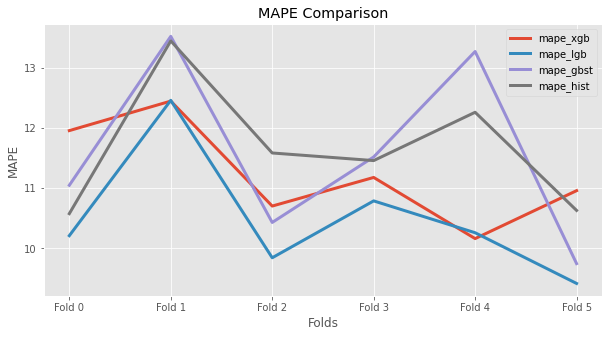

In [104]:
plt.rcParams["figure.figsize"] = (10,5)
df_final_plot[['mape_xgb', 'mape_lgb', 'mape_gbst', 'mape_hist']].plot(title='MAPE Comparison', linewidth = 3)
plt.ylabel('MAPE')
plt.xlabel('Folds')

* As represented in the plot, all models seem to be getting similar results, however **LGBM regressor**, seems to be getting best results among all in average of all folds, XGB is the best fitted model according to the metrics included.
* Results seem to have improved from methodology without lagged values [03_data_model_evaluation.ipynb](https://github.com/lucasbotellaroca/Covid-19_Reproduction_Rate_Estimator/blob/main/notebooks/03_data_model_evaluation.ipynb)

#### Export our model for later usage
Train model with last fold and export for shap analysis and front end interaction.

In [105]:

import pickle

X=df_time[df_time.columns[3:-1]]
y=df_time[df_time.columns[-1]]
X_train, X_test = X.iloc[0:1148], X.iloc[1148:1237]   
y_train, y_test = y.iloc[0:1148], y.iloc[1148:1237]

pickle.dump(model_lgb.fit(X_train,y_train), open('../models/model_lgbm_reg_lags', 'wb'))

[Up](#table_of_contents)
## Model Selection, Evaluation and Conclusion<a name="conclusion"></a>

In the presented notebook we have covered three different approaches **working with lagged values and excluding mobility indexes from the analysis**. This is due to the fact that we wanted to create a model that would be able to predict, and in order to get more precise predictions we would need to include reproduction rate as seen improving results,since the siginficance of that variable is big. Also, if a preddiction is intended to be made, mobility indexes are not available when applying restrictions, and als, they are found to have high multicollinearity with closure and mobility restrictions, therefore the effect of those restrictions is anulled by mobility indexes.

Overall the following three approaches were explored based on the presented methodology using lagged values of reproduction rate.

* **Approach 1:** Raw data no grouping of variables or PCA Analysis

* **Approach 2:** Grouping variables, decreasing dimensionality and correlation

* **Approach 3:** PCA


* All approaches have been evaluated with 6 different models: **XGB Regressor, LGBM Regressor, KNN, NuSVR, Histogram Gradient Regressor and Gradient Boosting Regressor**. 


* Over all approaches, Approach 2 was selected since as it has been mentioned,offers the most explanatory view due to the fact that grouping variables reduces multicollinearity. Over all 6 models, Boosting models (XGB Regressor, LGBM Regressor, Histogram Gradient Regressor and Gradient Boosting Regressor) were the ones fitting and estimating best our target variable. 


* A more in detail analysis was performed using time series split with Boosting Models and approach 2. Once this last analysis was performed it was evaluated that LGBM regressor was the model getting the most accurate results.


* Overall this model seems to be getting good metrics for mae, mse, rmse, and mape. However we have the opened issue detailed for R2 score. As mentioned, this is due to the fact that test sets tend to have less variance and therefore resulting in worst scores of R2. Predicticably the root cause behind this is that governments tend to apply restrictions to rech the desired reproduction rate of 1, and all values passed the first wave (March-April 2020) seem to be pointing in that direction. However this is less visible in this methodology including lagged values since predictions are a lot more precise.


* In conclusion this model offers good forecast of reproduction rate based on the variables included and the metrics studied including reproduction rate lags.


* A more precise evaluation of the model will be done studying shap values.